---
**Module 1 Final Project Submission**

* Student name: **Ru Keïn**
* Student pace: **Full-Time**
* Project review date/time: **November 1, 2019 at 10:00 AM PST**
* Instructor name: **James Irving, PhD**
* Blog post URL: www.hakkeray.com/datascience/projects/king-county-housing-data

**GOAL**
* How 

**OBJECTIVES**
* Identify null, missing, duplicate, and unreliable values in the data.
* Determine best approach for analyzing each predictor: continuous vs. categorical values
* Identify which combination of features (X) are the best predictors of the target (y). 

**QUESTIONS**
* Analyze Duplicates - is there a trend within houses re-sold for higher prices?
* 

---
# OBTAIN
* Import requisite libraries and data
* Inspect columns, dataypes
    * df.head()

In [1]:
# import PyPi package for cohort libraries using shortcut
#!pip install -U fsds_100719 # comment out after install so it won't run again
import fsds_100719 as fs
from fsds_100719.imports import *
plt.style.use('seaborn')
#inline_rc = dict(mpl.rcParams)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

fsds_1007219  v0.4.8 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 
> For convenient loading of standard modules use: `>> from fsds_100719.imports import *`



In [2]:
#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')

# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

In [3]:
# import dataset and review data types, columns, values
df = pd.read_csv('kc_house_data.csv') 
df.head()

id        date     price  bedrooms  ...      lat     long  sqft_living15  sqft_lot15
0  7129300520  10/13/2014  221900.0         3  ...  47.5112 -122.257           1340        5650
1  6414100192   12/9/2014  538000.0         3  ...  47.7210 -122.319           1690        7639
2  5631500400   2/25/2015  180000.0         2  ...  47.7379 -122.233           2720        8062
3  2487200875   12/9/2014  604000.0         4  ...  47.5208 -122.393           1360        5000
4  1954400510   2/18/2015  510000.0         3  ...  47.6168 -122.045           1800        7503

[5 rows x 21 columns]

---
# SCRUB 

**Q1: How should we address datatype of each feature to prepare it for EDA?**
    + 1. find and replace nulls
    + 2. re-cast datatypes (continuous, binary, categorical)
    + 3. check for duplicate observations (rows)
    + 4. preliminary analysis and visualizations
    + 5. decide which columns and rows to drop before EDA

    Custom Functions: 
    * hot_stats()
    * null_hunter()
    * corr_dict()

In [4]:
# HOT_STATS() function: display statistical summaries of a feature column
def hot_stats(data, column, verbose=False, target=None):
    """
    v.1.0
    Scans the values of a column within a dataframe
    and displays its datatype, nulls (incl. pct of total), 
    unique values, non-null value counts, as well as 
    statistical info if the datatype is numeric.
    
    Args:
    data: a dataframe
    
    column: a column within the data you want to scan *should be inside quotes ''
    
    KWargs:
    
    verbose: (optional) accepts a boolean (default=False). 
              verbose=True will display all unique values found.   
    
    target: (optional) accepts column name similar to column arg. 
             calculates correlation coefficient between feature and target using pandas data.corr() function. 
    
    example: 
    hot_stats(df, 'price')
    data = df
    column = 'price'
    
    Developer notes: additional features to add to v2 might
    include:
    -mode finder (frequency dict)
    -more functionality for string objects
    -side by side comparison between two features
    -OR ability to pass multiple columns at once and display all
    """
    # assigns variables to call later as shortcuts 
    feature = data[column]
    rdash = "-------->"
    ldash = "<--------"

    # figure out which hot_stats to display based on dtype 
    if feature.dtype == 'float':
        hot_stats = feature.describe().round(2)
    elif feature.dtype == 'int':
        hot_stats = feature.describe()
    elif feature.dtype == 'object' or 'category':
        hot_stats = feature.agg(['min','median','max'])
    else:
        hot_stats = None

    # display statistics (returns different info depending on datatype)
    print(rdash)
    print("HOT!STATS")
    print(ldash)
    # display column name formatted with underline
    print(f"\n{feature.name.upper()}")  
    # display the data type
    print(f"Data Type: {feature.dtype}\n")
    print(hot_stats)
    
    
    # find nulls and display total count and percentage
    if feature.isna().sum() > 0:  
        print(f"Found\n{feature.isna().sum()} Nulls out of {len(feature)}({round(feature.isna().sum()/len(feature)*100,2)}%)\n")
    else:
        print("\nNo Nulls Found!\n")
    
    # display value counts (non-nulls)
    print(f"Non-Null Value Counts:\n{feature.value_counts()}\n")
    
    # display count of unique values
    print(f"# Unique Values: {len(feature.unique())}\n")
    # displays all unique values found if verbose set to true
    if verbose == True:
        print(f"Unique Values:\n {feature.unique()}\n")
        
    # display correlation coefficient with target
    if target != None:
        corr = feature.corr(data[target]).round(4)
        print(f"Correlation with {target.upper()}: {corr}")

In [5]:
# NULL_HUNTER() function: display Null counts per column/feature
def null_hunter(df):
    print(f"Columns with Null Values")
    print("------------------------")
    for column in df:
        if df[column].isna().sum() > 0:
            print(f"{df[column].name}: \n{df[column].isna().sum()} out of {len(df[column])} ({round(df[column].isna().sum()/len(df[column])*100,2)}%)\n")

In [6]:
# CORRCOEF_DICT() function: calculates correlation coefficients assoc. with features and stores in a dictionary
def corr_dict(X, y):
    corr_coefs = []
    for x in X:
        corr = df[x].corr(df[y])
        corr_coefs.append(corr)
    
    corr_dict = {}
    
    for x, c in zip(X, corr_coefs):
        corr_dict[x] = c
    return corr_dict

In [7]:
# SUB_SCATTER() function: pass list of features (x_cols) and compare against target (or another feature)
def sub_scatter(data, x_cols, y, color=None, nrows=None, ncols=None):
    """
    Desc: displays set of scatterplots for multiple columns or features of a dataframe.
    pass in list of column names (x_cols) to plot against y-target (or another feature for 
    multicollinearity analysis)
    
    args: data, x_cols, y
    
    kwargs: color (default is magenta (#C839C5))
    
    example:
    
    x_cols = ['col1', 'col2', 'col3']
    y = 'col4'
    
    sub_scatter(df, x_cols, y)
    
    example with color kwarg:
    sub_scatter(df, x_cols, y, color=#)
    
    alternatively you can pass the column list and target directly:
    sub_scatter(df, ['col1', 'col2', 'col3'], 'price')

    """   
    if nrows == None:
        nrows = 1
    if ncols == None:
        ncols = 3
    if color == None:
        color = '#C839C5'
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,4))
    for x_col, ax in zip(x_cols, axes):
        data.plot(kind='scatter', x=x_col, y=y, ax=ax, color=color)

**FIRST GLANCE - Items to note**
    * There are 2 object datatypes that contain numeric values : 'date', 'sqft_basement'
    * The total value count is 21597. Some columns appear to be missing a substantial amount of data 
    (waterfront and yr_renovated).

In [8]:
# Display information about the variables, columns and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Before going further, a little house-keeping is in order. Let's breakdown the columns into groups based on feature-type as they relate to a real estate market context:

*Dependent Variable:*

TARGET
**price**

*Independent Variables:*

INTERIOR
**bedrooms, bathrooms, floors**

SIZE (SQUARE FOOTAGE)
**sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15**

LOCATION
**zipcode, lat, long, waterfront**

QUALITY
**condition, grade, yr_built, yr_renovated**

ANALYTICS
**date, id, view**

## Null Hunting (null_hunter)

    Let's start by hunting for nulls and then decide how to address each one (remove or replace) 
    in a manner that will not skew our analysis.

    NOTES:
      Drop null rows or columns as appropriate
      * df.isna().sum()
      * df.drop()
      * df.drop(['col1','col2'],axis=1)

      Coarse Binning NUMERICAL Data
      * replace with median or bin/convert to categorical
           * bin yr_built
           * bin sqft_basement
           * bin sqft_above
          
      CATEGORICAL data: 
      * make NaN own category OR replace with most common category
      * Fill in null values and recast variables for EDA
           * zipcode --> coded
           * View --> category
           * Waterfront --> boolean
           * yr_renovated --> is_reno (boolean)

In [9]:
# hunt for nulls
null_hunter(df)            

Columns with Null Values
------------------------
waterfront: 
2376 out of 21597 (11.0%)

view: 
63 out of 21597 (0.29%)

yr_renovated: 
3842 out of 21597 (17.79%)



    Before deciding how to handle nulls in the 3 columns above, let's take a closer look at each one and go from there.

## Data Casting (hot_stats)

### Binaries (Boolean)

    Although waterfront, yr_renovated, and view all contain numeric values, if we consider what each of them represents, they're more likely to be useful to the analysis if we convert them into binaries (is renovated or not, is waterfront or not, was viewed or not).

#### ['waterfront']

In [10]:
hot_stats(df, 'waterfront')

-------->
HOT!STATS
<--------

WATERFRONT
Data Type: float64

count    19221.00
mean         0.01
std          0.09
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: waterfront, dtype: float64
Found
2376 Nulls out of 21597(11.0%)

Non-Null Value Counts:
0.0    19075
1.0      146
Name: waterfront, dtype: int64

# Unique Values: 3



In [11]:
# This really should be a boolean (property either is waterfront or is not waterfront)

# Fill nulls with most common value (0.0) # float value
df['waterfront'].fillna(0.0, inplace=True)
#  verify changes
df['waterfront'].isna().sum()

0

In [12]:
# Convert datatype to boolean (values can be either 0 or 1)
df['is_waterfront'] = df['waterfront'].astype('bool')
# verify
df['is_waterfront'].value_counts()

False    21451
True       146
Name: is_waterfront, dtype: int64

#### ['yr_renovated']

In [13]:
hot_stats(df, 'yr_renovated')

-------->
HOT!STATS
<--------

YR_RENOVATED
Data Type: float64

count    17755.00
mean        83.64
std        399.95
min          0.00
25%          0.00
50%          0.00
75%          0.00
max       2015.00
Name: yr_renovated, dtype: float64
Found
3842 Nulls out of 21597(17.79%)

Non-Null Value Counts:
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

# Unique Values: 71



In [14]:
# This feature is also heavily skewed with zero values. 
# It should also be treated as a boolean since a property is either renovated or it's not).

# fill nulls with most common value (0)
df['yr_renovated'].fillna(0.0, inplace=True) # use float value to match current dtype

# verify change
df['yr_renovated'].isna().sum()

0

In [15]:
# Use numpy arrays to create binarized column 'is_renovated'
is_renovated = np.array(df['yr_renovated'])
is_renovated[is_renovated >= 1] = 1
df['is_renovated'] = is_renovated

In [16]:
df['is_renovated'].value_counts()

0.0    20853
1.0      744
Name: is_renovated, dtype: int64

In [17]:
# Convert to boolean
df['is_renovated'] = df['is_renovated'].astype('bool')

# verify
df['is_renovated'].value_counts()

False    20853
True       744
Name: is_renovated, dtype: int64

#### ['view']

In [18]:
hot_stats(df, 'view')

-------->
HOT!STATS
<--------

VIEW
Data Type: float64

count    21534.00
mean         0.23
std          0.77
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          4.00
Name: view, dtype: float64
Found
63 Nulls out of 21597(0.29%)

Non-Null Value Counts:
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

# Unique Values: 6



In [19]:
# Once again, almost all values are 0 .0

# replace nulls with most common value (0). 
df['view'].fillna(0, inplace=True)

#verify
df['view'].isna().sum()

0

    Since view has a finite set of values (0 to 4) we could assign category codes. However, considering the high number of zeros, it makes more sense to binarize the values into a new column representing whether or not the property was viewed.

In [20]:
# create new boolean column for view:
df['viewed'] = df['view'].astype('bool')

# verify
df['viewed'].dtype

dtype('bool')

In [21]:
binaries = ['is_waterfront', 'is_renovated', 'viewed']

# check correlation coefficients
corr_dict(binaries, 'price')

{'is_waterfront': 0.2643062804831157,
 'is_renovated': 0.11754308700194362,
 'viewed': 0.3562431893938032}

    None of these correlation values look strong enough to be predictive of price.

### Categories - Nominal

#### ['floors']

In [22]:
hot_stats(df, 'floors', target='price')

-------->
HOT!STATS
<--------

FLOORS
Data Type: float64

count    21597.00
mean         1.49
std          0.54
min          1.00
25%          1.00
50%          1.50
75%          2.00
max          3.50
Name: floors, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

# Unique Values: 6

Correlation with PRICE: 0.2568


    Although you could theoretically have any number of floors, this really should be 
    treated as a category (i.e. contains finite possible values). Assuming this is 
    probably true for the other interior features (bedrooms, bathrooms). 
    
    Let's look at a scatter plot using the sub_scatter function.

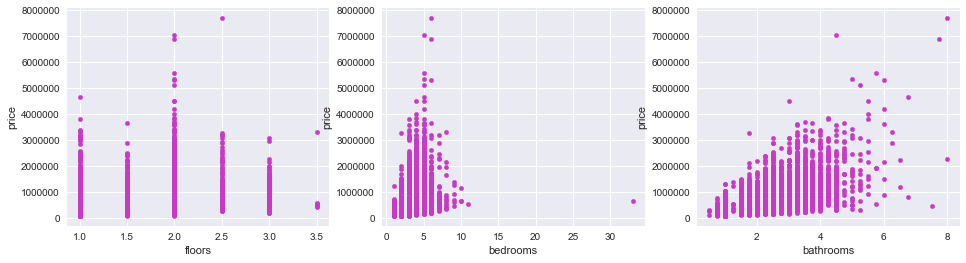

In [26]:
y = 'price'
x_cols = ['floors','bedrooms', 'bathrooms']

sub_scatter(df, x_cols, y)

     Bathrooms appears to have a very linear relationship with price. Bedrooms is 
     somewhat linear up to a certain point. Let's look at the hot stats for both.

#### ['bedrooms']

In [27]:
hot_stats(df, 'bedrooms', target='price')

-------->
HOT!STATS
<--------

BEDROOMS
Data Type: int64

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

No Nulls Found!

Non-Null Value Counts:
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

# Unique Values: 12

Correlation with PRICE: 0.3088


    As expected, not a significant correlation between bedrooms and price.

#### ['bathrooms']

In [28]:
hot_stats(df, 'bathrooms', target='price')

-------->
HOT!STATS
<--------

BATHROOMS
Data Type: float64

count    21597.00
mean         2.12
std          0.77
min          0.50
25%          1.75
50%          2.25
75%          2.50
max          8.00
Name: bathrooms, dtype: float64

No Nulls Found!

Non-Null Value Counts:
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

# Unique Values: 29

Correlation with PRICE: 0.5259


    Bathrooms is the only feature showing correlation over the 0.5 threshold. 
    We can probably drop the other two as predictor candidates, especially if 
    they exhbit multicollinearity (we'll explore that in more detail later).

In [29]:
# Create category columns for interior features: floors, bedrooms, and bathrooms
df['floor_cat'] = df['floors'].astype('category')
df['bedroom_cat'] = df['bedrooms'].astype('category')
df['bathroom_cat'] = df['bathrooms'].astype('category')

In [30]:
# save correlation coefficients higher than 0.5 in a dict
corr_thresh_dict = {}
corrs = ['bathrooms']
corr_thresh_dict = corr_dict(corrs, 'price')
corr_thresh_dict

{'bathrooms': 0.5259056214532012}

### Categories - Ordinal

#### ['condition']

In [31]:
hot_stats(df, 'condition', target='price')

-------->
HOT!STATS
<--------

CONDITION
Data Type: int64

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

No Nulls Found!

Non-Null Value Counts:
3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

# Unique Values: 5

Correlation with PRICE: 0.0361


In [32]:
# Condition should be treated as ordinal since there is a relationship between 
# the values (ranking scale from 1 to 5)
cat_dtype = pd.api.types.CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)

# Recast condition as an ordered category
df['condition_cat'] = df['condition'].astype(cat_dtype)

# verify
df['condition_cat'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)

#### ['grade']

In [33]:
# View grade stats
hot_stats(df, 'grade', target='price')

-------->
HOT!STATS
<--------

GRADE
Data Type: int64

count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

No Nulls Found!

Non-Null Value Counts:
7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

# Unique Values: 11

Correlation with PRICE: 0.668


In [34]:
# Grade should also be treated as an ordinal category

# create ranking scale from 1 to 13
cat_dtype = pd.api.types.CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ordered=True)

# Create new ordered category column for grade
df['grade_cat'] = df['grade'].astype(cat_dtype)

# verify
df['grade_cat'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ordered=True)

In [35]:
corrs.append('grade')

corr_thresh_dict = corr_dict(corrs, 'price')

corr_thresh_dict

{'bathrooms': 0.5259056214532012, 'grade': 0.6679507713876452}

    Condition is useless, but grade is our highest coefficient so far at 0.68! 
    We can also see (below) a clear linear relationship between grade and price. 

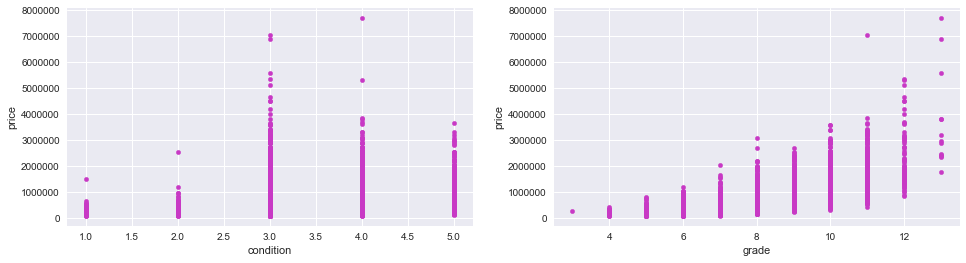

In [36]:
# visualize on a scatter plot
sub_scatter(df, ['condition', 'grade'], 'price', nrows=1, ncols=2)

#### ['yr_built'] 

In [37]:
hot_stats(df, 'yr_built', target='price')

-------->
HOT!STATS
<--------

YR_BUILT
Data Type: int64

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

No Nulls Found!

Non-Null Value Counts:
2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

# Unique Values: 116

Correlation with PRICE: 0.054


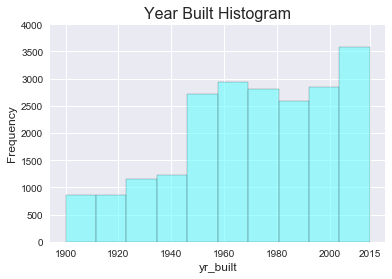

In [38]:
# Let's look at the data distribution of yr_built values 

fig, ax = plt.subplots()
df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
xticks = (1900, 1920, 1940, 1960, 1980, 2000, 2015)
yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
plt.xticks(xticks);
plt.yticks(yticks);
ax.set_title('Year Built Histogram', fontsize=16)
ax.set_xlabel('yr_built', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

    Most houses were built during the second half of the century (after 1950)

    We'll use adaptive binning based on quantiles for yr_built in order to create
    a more normal distribution.

In [39]:
# define a binning scheme with custom ranges based on quantiles
quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['yr_built'].quantile(quantile_list)

quantiles # 1900, 1951, 1975, 1997, 2015

0.00    1900.0
0.25    1951.0
0.50    1975.0
0.75    1997.0
1.00    2015.0
Name: yr_built, dtype: float64

In [40]:
# Bin the years in to ranges based on the quantiles.
# label the bins for each value 
# store the yr_range and its corresponding yr_label as new columns in df

yb_bins = [1900, 1951, 1975, 1997, 2015]

yb_labels = [1, 2, 3, 4]

# create a new column for the category range values
df['yb_range'] = pd.cut(df['yr_built'], bins=yb_bins)

# create a new column for the category labels
df['yb_cat'] = pd.cut(df['yr_built'], bins=yb_bins, labels=yb_labels)

In [41]:
# view the binned features corresponding to each yr_built 
df[['yr_built','yb_cat', 'yb_range']].iloc[9003:9007] # picking a random index location

yr_built yb_cat      yb_range
9003      1996      3  (1975, 1997]
9004      1959      2  (1951, 1975]
9005      2003      4  (1997, 2015]
9006      1902      1  (1900, 1951]

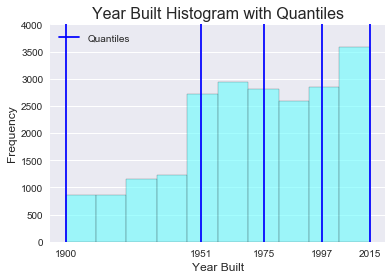

In [42]:
# Let’s look at the original distribution histogram again with the quantiles added:

fig, ax = plt.subplots()

df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='b')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    xticks = quantiles
    yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
    plt.xticks(xticks);
    plt.yticks(yticks);
    ax.set_title('Year Built Histogram with Quantiles',fontsize=16)
    ax.set_xlabel('Year Built', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

In [43]:
# values look much more normally distributed between the new categories
df.yb_cat.value_counts()

2    5515
3    5411
1    5326
4    5258
Name: yb_cat, dtype: int64

Text(0, 0.5, 'Frequency')

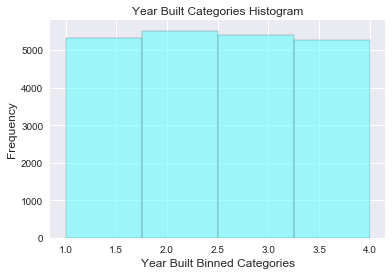

In [44]:
# visualize the distribution of the binned values

fig, ax = plt.subplots()
df['yb_cat'].hist(bins=4, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
ax.set_title('Year Built Categories Histogram', fontsize=12)
ax.set_xlabel('Year Built Binned Categories', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [45]:
# get_dummies for one-hot encoding
yb_dummies = pd.get_dummies(df['yb_cat'], prefix='yb', drop_first=True)

In [46]:
df = pd.concat([df, yb_dummies], axis=1)

In [47]:
df.head(2)

id        date     price  bedrooms  bathrooms  ...      yb_range  yb_cat  yb_2  yb_3  yb_4
0  7129300520  10/13/2014  221900.0         3       1.00  ...  (1951, 1975]       2     1     0     0
1  6414100192   12/9/2014  538000.0         3       2.25  ...  (1900, 1951]       1     0     0     0

[2 rows x 34 columns]

#### ['zipcode']

In [48]:
hot_stats(df, 'zipcode')

-------->
HOT!STATS
<--------

ZIPCODE
Data Type: int64

count    21597.000000
mean     98077.951845
std         53.513072
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64

No Nulls Found!

Non-Null Value Counts:
98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

# Unique Values: 70



Text(0, 0.5, 'Frequency')

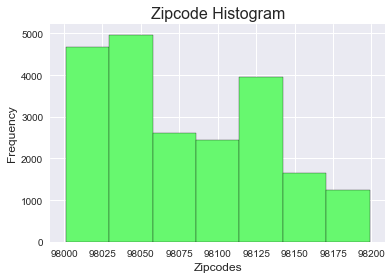

In [49]:
# There are 70 unique zipcode values
# Let's look at the data distribution of zipcode values 
fig, ax = plt.subplots()
df['zipcode'].hist(bins=7, color='#67F86F',
edgecolor='black', grid=True)
ax.set_title('Zipcode Histogram', fontsize=16)
ax.set_xlabel('Zipcodes', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [50]:
# Let’s define a binning scheme with custom ranges for the zipcode values 
# The bins will be created based on quantiles

quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['zipcode'].quantile(quantile_list)

quantiles # 98001, 98033, 98065, 98118, 98199

0.00    98001.0
0.25    98033.0
0.50    98065.0
0.75    98118.0
1.00    98199.0
Name: zipcode, dtype: float64

In [51]:
# Now we can label the bins for each value and store both the bin range 
# and its corresponding label.

zip_bins = [98000, 98033, 98065, 98118, 98200]

zip_labels = [1, 2, 3, 4]

df['zip_range'] = pd.cut(df['zipcode'], bins=zip_bins)

df['zip_cat'] = pd.cut(df['zipcode'], bins=zip_bins, labels=zip_labels)

# view the binned features 
df[['zipcode','zip_cat', 'zip_range']].iloc[9000:9005] # pick a random index

zipcode zip_cat       zip_range
9000    98092       3  (98065, 98118]
9001    98117       3  (98065, 98118]
9002    98144       4  (98118, 98200]
9003    98038       2  (98033, 98065]
9004    98004       1  (98000, 98033]

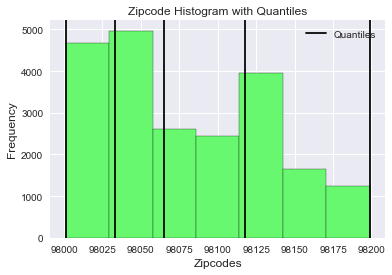

In [52]:
# visualize the quantiles in the original distribution histogram

fig, ax = plt.subplots()

df['zipcode'].hist(bins=7, color='#67F86F', edgecolor='black', grid=True)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='black')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title('Zipcode Histogram with Quantiles',fontsize=12)
    ax.set_xlabel('Zipcodes', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

In [53]:
# get_dummies for one-hot encoding
zip_dummies = pd.get_dummies(df['zip_cat'], prefix='zip', drop_first=True)

In [54]:
# drop first dummy to avoid multicollinearity trap
df = pd.concat([df, zip_dummies], axis=1)

In [55]:
# inspect
df.head()

id        date     price  bedrooms  ...  zip_cat  zip_2  zip_3  zip_4
0  7129300520  10/13/2014  221900.0         3  ...        4      0      0      1
1  6414100192   12/9/2014  538000.0         3  ...        4      0      0      1
2  5631500400   2/25/2015  180000.0         2  ...        1      0      0      0
3  2487200875   12/9/2014  604000.0         4  ...        4      0      0      1
4  1954400510   2/18/2015  510000.0         3  ...        3      0      1      0

[5 rows x 39 columns]

#### ['lat']  ['long']

    The coordinates for latitude and longitude are not going to be useful to us since we already have zipcodes as a geographic identifier.  

In [56]:
# lmplot



---
### DateTime
We need to convert the datatypes of numeric values currently stored as objects. This will allow us to include them in the preliminary exploration and analysis. 

    * date -> recast as datetime
    * sqft_basement -> recast as float

#### ['date'] 
convert to datetime

In [57]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

In [58]:
hot_stats(df, 'date')

-------->
HOT!STATS
<--------

DATE
Data Type: datetime64[ns]

min   2014-05-02
max   2015-05-27
Name: date, dtype: datetime64[ns]

No Nulls Found!

Non-Null Value Counts:
2014-06-23    142
2014-06-25    131
2014-06-26    131
2014-07-08    127
2015-04-27    126
             ... 
2014-07-27      1
2015-03-08      1
2014-11-02      1
2015-05-15      1
2015-05-24      1
Name: date, Length: 372, dtype: int64

# Unique Values: 372



### Continuous

* SQUARE-FOOTAGE

Redundancy check: is there any overlap in the measurements?

* sqft_living = sqft_basement + sqft_above ?
* sqft_lot - sqft_living = sqft_above ?


**Continuous Variables:**
a continuous variable can take on any value within a range

* **sqft_living** --> highest corr : price (before transformation/scaling); most normal distribution
* sqft_lot --> not normal distribution
* sqft_living15 #Highly skewed
* sqft_lot15 #Highly skewed
* sqft_above #High corr with sqft_living
* sqft_basement #Very high number of null values --> treat '0' = no basement?


#### ['sqft_basement']

In [59]:
# let's figure out what datatype is more appropriate for sqft_basement
hot_stats(df, 'sqft_basement')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: object

min    0.0
max      ?
Name: sqft_basement, dtype: object

No Nulls Found!

Non-Null Value Counts:
0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1548.0        1
2730.0        1
1930.0        1
1880.0        1
2500.0        1
Name: sqft_basement, Length: 304, dtype: int64

# Unique Values: 304



In [60]:
# Note the majority of the values are zero...we could bin this as a binary 
# where the property either has a basement or does not...

# For now we'll replace '?'s with string value '0.0'
df['sqft_basement'].replace(to_replace='?', value='0.0', inplace=True)

In [61]:
# and change datatype to float.
df['sqft_basement'] = df['sqft_basement'].astype('float')

In [62]:
hot_stats(df, 'sqft_basement', target='price')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: float64

count    21597.00
mean       285.72
std        439.82
min          0.00
25%          0.00
50%          0.00
75%        550.00
max       4820.00
Name: sqft_basement, dtype: float64

No Nulls Found!

Non-Null Value Counts:
0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

# Unique Values: 303

Correlation with PRICE: 0.3211


    That's much better. Although, lot's of zeros could be a problem. 
    Let's check out the other square-footage features and see if those might be more useful.

#### ['sqft_above']

In [63]:
hot_stats(df, 'sqft_above', target='price')

-------->
HOT!STATS
<--------

SQFT_ABOVE
Data Type: int64

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

# Unique Values: 942

Correlation with PRICE: 0.6054


    Some correlation with price here!

#### ['sqft_living']

In [64]:
hot_stats(df, 'sqft_living', target='price')

-------->
HOT!STATS
<--------

SQFT_LIVING
Data Type: int64

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

# Unique Values: 1034

Correlation with PRICE: 0.7019


    sqft_living shows correlation value of 0.7 with price -- our highest coefficient yet!

In [65]:
# add sqft_living and sqft_above to our correlation threshold dict
corrs = ['sqft_living', 'grade', 'sqft_above', 'bathrooms']
corr_thresh_dict = corr_dict(corrs, 'price')
corr_thresh_dict

{'sqft_living': 0.7019173021377595,
 'grade': 0.6679507713876452,
 'sqft_above': 0.6053679437051795,
 'bathrooms': 0.5259056214532012}

#### ['sqft_lot']

In [66]:
hot_stats(df, 'sqft_lot', target='price')

-------->
HOT!STATS
<--------

SQFT_LOT
Data Type: int64

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

No Nulls Found!

Non-Null Value Counts:
5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

# Unique Values: 9776

Correlation with PRICE: 0.0899


#### ['sqft_living15']

In [67]:
hot_stats(df, 'sqft_living15', target='price')

-------->
HOT!STATS
<--------

SQFT_LIVING15
Data Type: int64

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

# Unique Values: 777

Correlation with PRICE: 0.5852


    We've identified another coefficient over the 0.5 correlation threshold.

In [68]:
hot_stats(df, 'sqft_lot15', target='price')

-------->
HOT!STATS
<--------

SQFT_LOT15
Data Type: int64

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

No Nulls Found!

Non-Null Value Counts:
5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

# Unique Values: 8682

Correlation with PRICE: 0.0828


In [69]:
corrs.append('sqft_living15')

corr_thresh_dict = corr_dict(corrs, 'price')
corr_thresh_dict

{'sqft_living': 0.7019173021377595,
 'grade': 0.6679507713876452,
 'sqft_above': 0.6053679437051795,
 'bathrooms': 0.5259056214532012,
 'sqft_living15': 0.5852412017040663}

### Index

#### ['id']

In [70]:
hot_stats(df, 'id')

-------->
HOT!STATS
<--------

ID
Data Type: int64

count    2.159700e+04
mean     4.580474e+09
std      2.876736e+09
min      1.000102e+06
25%      2.123049e+09
50%      3.904930e+09
75%      7.308900e+09
max      9.900000e+09
Name: id, dtype: float64

No Nulls Found!

Non-Null Value Counts:
795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

# Unique Values: 21420



The primary key we'd use as an index for this data set would be 'id'. Our assumption therefore is that the 'id' for each observation (row) is unique. Let's do a quick scan for duplicate entries to confirm this is true.

In [71]:
# check for duplicate id's
df['id'].duplicated().value_counts() 

False    21420
True       177
Name: id, dtype: int64

In [72]:
# Looks like there are in fact some duplicate ID's! Not many, but worth investigating.

# Let's flag the duplicate id's by creating a new column 'is_dupe':
df.loc[df.duplicated(subset='id', keep=False), 'is_dupe'] = 1 # mark all duplicates 

# verify all duplicates were flagged
df.is_dupe.value_counts() # 353

1.0    353
Name: is_dupe, dtype: int64

In [73]:
# the non-duplicate rows show as null in our new column
df.is_dupe.isna().sum()

21244

In [74]:
# Replace 'nan' rows in is_dupe with 0.0
df.loc[df['is_dupe'].isna(), 'is_dupe'] = 0

# verify
df['is_dupe'].unique()

array([0., 1.])

In [75]:
# convert column to boolean data type
df['is_dupe'] = df['is_dupe'].astype('bool')
# verify
df['is_dupe'].value_counts()

False    21244
True       353
Name: is_dupe, dtype: int64

In [76]:
# Let's now copy the duplicates into a dataframe subset for closer inspection
# It's possible the pairs contain data missing from the other which 
# we can use to fill nulls identified previously.

df_dupes = df.loc[df['is_dupe'] == True]

# check out the data discrepancies between duplicates (first 3 pairs)
df_dupes.head(6)

id       date      price  bedrooms  bathrooms  ...  zip_cat  zip_2  zip_3  zip_4  is_dupe
93   6021501535 2014-07-25   430000.0         3       1.50  ...        3      0      1      0     True
94   6021501535 2014-12-23   700000.0         3       1.50  ...        3      0      1      0     True
313  4139480200 2014-06-18  1380000.0         4       3.25  ...        1      0      0      0     True
314  4139480200 2014-12-09  1400000.0         4       3.25  ...        1      0      0      0     True
324  7520000520 2014-09-05   232000.0         2       1.00  ...        4      0      0      1     True
325  7520000520 2015-03-11   240500.0         2       1.00  ...        4      0      0      1     True

[6 rows x 40 columns]

In [77]:
# Looks like the only discrepancies might occur between 'date' and 'price' values
# Some of the prices nearly double, even when the re-sale is just a few months later!

df_dupes.loc[df_dupes['id'] == 6021501535]

id       date     price  bedrooms  bathrooms  ...  zip_cat  zip_2  zip_3  zip_4  is_dupe
93  6021501535 2014-07-25  430000.0         3        1.5  ...        3      0      1      0     True
94  6021501535 2014-12-23  700000.0         3        1.5  ...        3      0      1      0     True

[2 rows x 40 columns]

In [78]:
# Set index of df_dupes to 'id'
df_dupes.set_index('id')
# Set index of df to 'id'
df.set_index('id')

date     price  bedrooms  bathrooms  ...  zip_2  zip_3  zip_4  is_dupe
id                                                    ...                              
7129300520 2014-10-13  221900.0         3       1.00  ...      0      0      1    False
6414100192 2014-12-09  538000.0         3       2.25  ...      0      0      1    False
5631500400 2015-02-25  180000.0         2       1.00  ...      0      0      0    False
2487200875 2014-12-09  604000.0         4       3.00  ...      0      0      1    False
1954400510 2015-02-18  510000.0         3       2.00  ...      0      1      0    False
...               ...       ...       ...        ...  ...    ...    ...    ...      ...
263000018  2014-05-21  360000.0         3       2.50  ...      0      1      0    False
6600060120 2015-02-23  400000.0         4       2.50  ...      0      0      1    False
1523300141 2014-06-23  402101.0         2       0.75  ...      0      0      1    False
291310100  2015-01-16  400000.0         3       2.50  ...      0      0      0    False
1523300157 2014-10-15  325000.0         2       0.75  ...      0      0      1    False

[21597 rows x 39 columns]

In [79]:
# Before we drop the duplicates, let's save a backup copy of the current df using pickle.
import pickle
# create pickle data_object
df_predrops = df

In [80]:
with open('data.pickle', 'wb') as f:
    pickle.dump(df_predrops, f, pickle.HIGHEST_PROTOCOL)

In [81]:
# import df (pre-drops) with pickle
# with open('data.pickle', 'rb') as f:
    #df2 = pickle.load(f)

In [82]:
# let's drop the first occurring duplicate rows and keep the last ones 
# (since those more accurately reflect latest market data)

# save original df.shape for comparison after dropping duplicate rows
predrop = df.shape # (21597, 28)

# first occurrence, keep last
df.drop_duplicates(subset='id', keep ='last', inplace = True) 

# verify dropped rows by comparing df.shape before and after values
print(f"predrop: {predrop}")
print(f"postdrop: {df.shape}")

predrop: (21597, 40)
postdrop: (21420, 40)


## Target

#### ['price']

In [83]:
# Let's take a quick look at the statistical data for our dependent variable (price):
hot_stats(df, 'price')

-------->
HOT!STATS
<--------

PRICE
Data Type: float64

count      21420.00
mean      541861.43
std       367556.94
min        78000.00
25%       324950.00
50%       450550.00
75%       645000.00
max      7700000.00
Name: price, dtype: float64

No Nulls Found!

Non-Null Value Counts:
450000.0    172
350000.0    167
550000.0    157
500000.0    151
425000.0    149
           ... 
234975.0      1
804995.0      1
870515.0      1
336950.0      1
884744.0      1
Name: price, Length: 3595, dtype: int64

# Unique Values: 3595



Keeping the below numbers in mind could be helpful as we start exploring the data:

* range: 78,000 to 7,700,000
* mean value: 540,296
* median value: 450,000

In [85]:
# At this point we can begin exploring the data. Let's first review our current feature list and get rid
# of any columns we no longer need. As we go through our analysis we'll decide which additional columns to 
# drop, transform, scale, normalize, etc.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 40 columns):
id               21420 non-null int64
date             21420 non-null datetime64[ns]
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       21420 non-null float64
view             21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
yr_built         21420 non-null int64
yr_renovated     21420 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
is_waterfront    21420 non-null bool
is_renovated     21420 non-nu

In [264]:
# cols to drop bc irrelevant to linreg model or using new versions instead:
hot_drop = ['date','id','lat','long','waterfront', 'yr_renovated', 'view', 'floors', 'bedrooms', 'bathrooms', 'condition', 'grade', 'yr_built', 'zipcode', 'yb_range', 'zip_range']

In [265]:
# store hot_drop columns in separate df
df_drops = df[hot_drop].copy()

In [266]:
# set index of df_drops to 'id'
df_drops.set_index('id')
# verify
df_drops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 16 columns):
date            21420 non-null datetime64[ns]
id              21420 non-null int64
lat             21420 non-null float64
long            21420 non-null float64
waterfront      21420 non-null float64
yr_renovated    21420 non-null float64
view            21420 non-null float64
floors          21420 non-null float64
bedrooms        21420 non-null int64
bathrooms       21420 non-null float64
condition       21420 non-null int64
grade           21420 non-null int64
yr_built        21420 non-null int64
zipcode         21420 non-null int64
yb_range        21334 non-null category
zip_range       21420 non-null category
dtypes: category(2), datetime64[ns](1), float64(7), int64(6)
memory usage: 2.5 MB


In [267]:
# drop it like its hot >> df.drop(hot_drop, axis=1, inplace=True)
df.drop(hot_drop, axis=1, inplace=True)

# verify dropped columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 24 columns):
price            21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
is_waterfront    21420 non-null bool
is_renovated     21420 non-null bool
viewed           21420 non-null bool
floor_cat        21420 non-null category
bedroom_cat      21420 non-null category
bathroom_cat     21420 non-null category
condition_cat    21420 non-null category
grade_cat        21420 non-null category
yb_cat           21334 non-null category
yb_2             21420 non-null uint8
yb_3             21420 non-null uint8
yb_4             21420 non-null uint8
zip_cat          21420 non-null category
zip_2            21420 non-null uint8
zip_3            21420 non-null uint8
zip_4            21420 non-null u

In [268]:
# cols kept for EDA:

# target variable
target = ['price']

# categorical:
cats = ['bathroom_cat', 'bedroom_cat', 'floor_cat', 'grade_cat', 'condition_cat', 'zip_cat', 'yb_cat']

#numeric/continuous:
nums = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot', 'sqft_lot15']

# binary/categorical:
binned = ['is_waterfront', 'is_renovated', 'viewed', 'is_dupe']

# dummies
dummies = ['yb_2','yb_3', 'yb_4', 'zip_2', 'zip_3', 'zip_4']

In [269]:
# Create dataframe subsets for each datatype group

df_binned = df[binned]
df_cats = df[cats]
df_nums = df[nums]
df_dummies = df[dummies]
df_target = df[target]

In [270]:
df.head()

price  sqft_living  sqft_lot  sqft_above  ...  zip_2  zip_3  zip_4  is_dupe
0  221900.0         1180      5650        1180  ...      0      0      1    False
1  538000.0         2570      7242        2170  ...      0      0      1    False
2  180000.0          770     10000         770  ...      0      0      0    False
3  604000.0         1960      5000        1050  ...      0      0      1    False
4  510000.0         1680      8080        1680  ...      0      1      0    False

[5 rows x 24 columns]

In [272]:
# drop it like its hot >> df.drop(hot_drop, axis=1, inplace=True)
df.drop(dummies, axis=1, inplace=True)

# verify dropped columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 18 columns):
price            21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
is_waterfront    21420 non-null bool
is_renovated     21420 non-null bool
viewed           21420 non-null bool
floor_cat        21420 non-null category
bedroom_cat      21420 non-null category
bathroom_cat     21420 non-null category
condition_cat    21420 non-null category
grade_cat        21420 non-null category
yb_cat           21334 non-null category
zip_cat          21420 non-null category
is_dupe          21420 non-null bool
dtypes: bool(4), category(7), float64(2), int64(5)
memory usage: 1.5 MB


# EXPLORE:
    
    EDA CHECKLIST:
    linearity (scatter matrices)
    multicollinearity (heatmaps)
    distributions (histograms, KDEs)
    regression (regplots, qqplots
    
    SCRUB 2: data transformations
    outliers
    scales/ranges
    log transform (to improve reg algorithms)
    
    FEATURE SELECTION
    stepwise selection

## Linearity
    During the scrub process we made some assumptions and guesses based on correlation coefficients 
    and other values. Let's see what the visualizations tell us by creating some scatter plots.

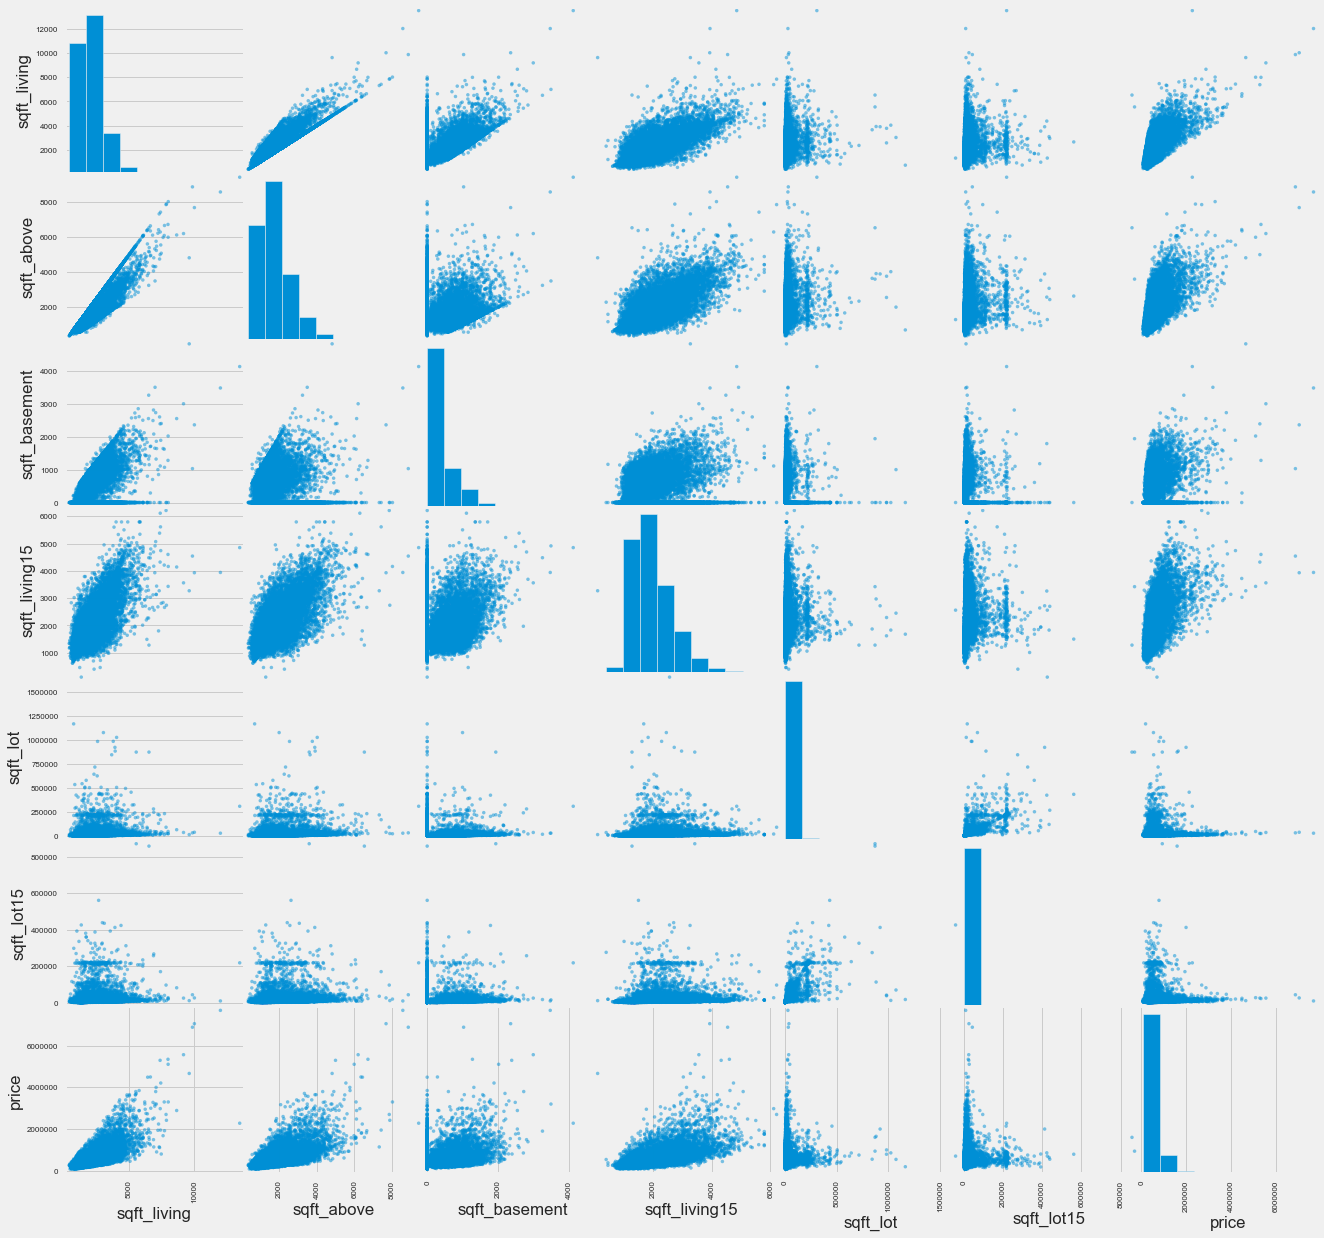

In [374]:
plt.style.use('fivethirtyeight')
# add target to numeric df subset
df_nums['price'] = df.price

# plot scatter matrix 
pd.plotting.scatter_matrix(df_nums, figsize=(20,20));

    We can see a clear linear relationship between price and sqft_living, sqft_above, sqft_living15 and somewhat
    so for sqft_basement. However, it looks like there is covariance among these variables as well.

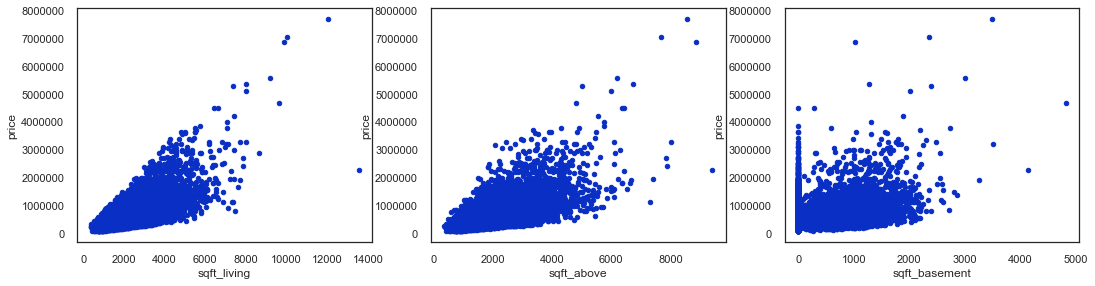

In [274]:
# Visualize the relationship between square-footages and price
sqft_int = ['sqft_living', 'sqft_above', 'sqft_basement']
sub_scatter(df, sqft_int, 'price', color='#0A2FC4') #20C5C6

    Linear relationships with price show up clearly for sqft_living, sqft_above, sqft_living15.

    These features look like they probably have some covariance as well - in fact, the square footages probably 
    overlap. (In other words sqft_above and sqft_basement could be part of the total sqft_living measurement).

## Multicollinearity
**Q3: which predictors are closely related (and should be dropped)?**


    + multicollinearity: remove variable having most corr with largest # of variables

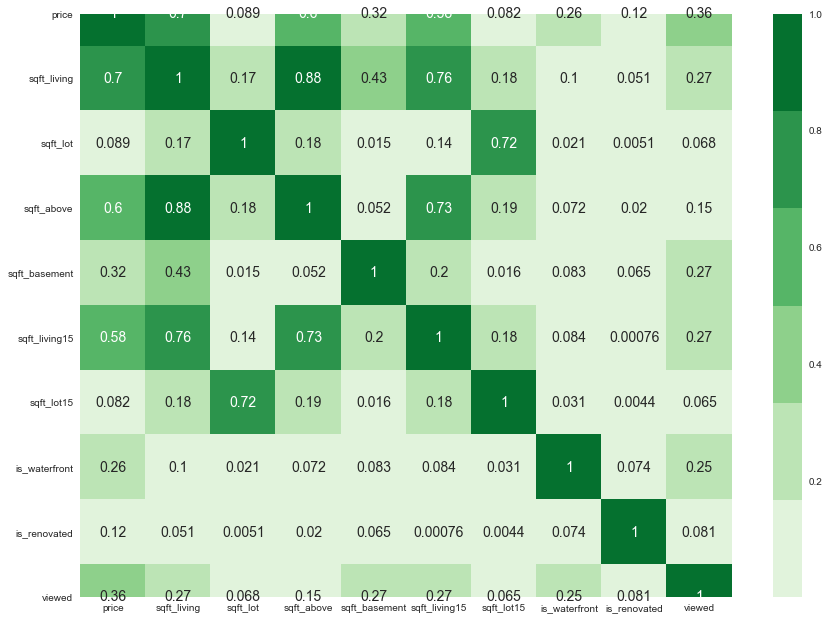

In [349]:
# Heatmap: Absolute Correlation Matrix
corr = df.drop('is_dupe', axis=1).corr()

plt.figure(figsize=(13,10))
sns.heatmap(data=corr.abs(), annot=True, cmap=sns.color_palette('Greens'))
plt.show()

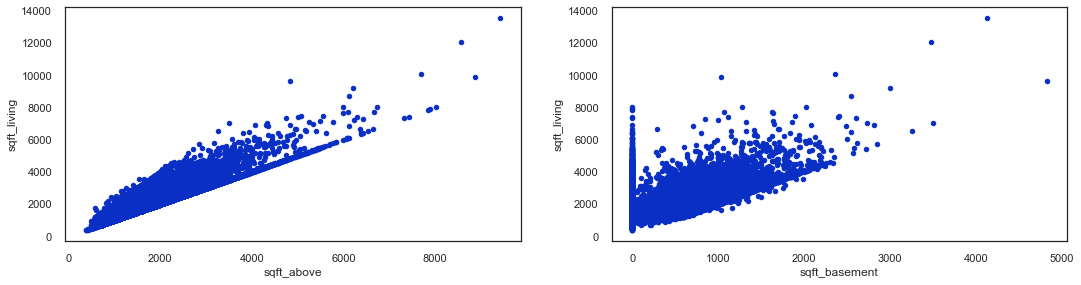

In [275]:
# Visualize multicollinearity between interior square-footages
x_cols = ['sqft_above', 'sqft_basement']
sub_scatter(df, x_cols, 'sqft_living', ncols = 2, color='#0A2FC4')  #FD6F6B lightred

    Yikes. These are extremely linear. Just for fun, let's crunch the numbers...

**QUESTION: Is there any overlap in square-footage measurements?**

In [276]:
# check random location in the index
print(df['sqft_living'].iloc[0]) #1180
print(df['sqft_above'].iloc[0] + df['sqft_basement'].iloc[0]) #1180

print(df['sqft_living'].iloc[1]) #2570
print(df['sqft_above'].iloc[1] + df['sqft_basement'].iloc[1]) #2570

1180
1180.0
2570
2570.0


In [277]:
# sqft_living == sqft_basement + sqft_above ?
# sqft_lot - sqft_living == sqft_above ?

sqft_lv = np.array(df['sqft_living'])
sqft_ab = np.array(df['sqft_above'])
sqft_bs = np.array(df['sqft_basement'])

sqft_ab + sqft_bs == sqft_lv #array([ True,  True,  True, ...,  True,  True,  True])

array([ True,  True,  True, ...,  True,  True,  True])

In [278]:
# check them all at once
if sqft_ab.all() + sqft_bs.all() == sqft_lv.all():
    print("True")

True


**ANSWER: Yes. Sqft_living is the sum of sqft_above and sqft_basement.**

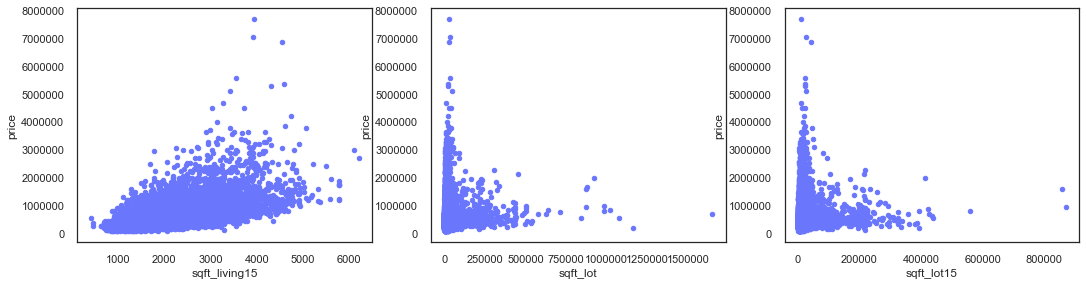

In [279]:
y = 'price'
x_cols = ['sqft_living15', 'sqft_lot', 'sqft_lot15']

sub_scatter(df, x_cols, y, color='#6A76FB')

    Sqft_living15 (the square-footage of the neighbors' houses) looks to be the only one that correlates well with 
    price. However, as we saw above, this also correlates with square-foot living, so we'd run into some 
    multicollinearity issues if we kept both. Since sqft_living is higher, that is likely to be a better candidate 
    for prediction.

**QUESTION: Can we combine features for a higher correlation?**

In [280]:
# Correlation coefficient for sqft_living and price
np.corrcoef(df['sqft_living'], df['price'])[0][1]

0.701294859117587

In [281]:
# Correlation coefficient for sqft_living15 and price
np.corrcoef(df['sqft_living15'], df['price'])[0][1]

0.5837916994556072

In [282]:
# Let's see if we can combine them for a higher correlation

weights = np.linspace(0, 1, 50)

best_weight = 0
max_corr = 0

for weight in weights:
    #creating a new feature by taking a weighted sum
    new_feature = weight*df['sqft_living'] + (1 - weight)*df['sqft_living15']
    
    corr_coef = np.corrcoef(new_feature, df['price'])[0][1]
    if np.abs(corr_coef) > max_corr:
        max_corr = np.abs(corr_coef)
        best_weight = weight
        
print(best_weight, 1 - best_weight)

0.7755102040816326 0.22448979591836737


    The combined correlation value of sqft_living and sqft_living15 (0.77) is indeed higher
    than sqft_living by itself (0.7).

In [283]:
# Let's see if we can also combine bedrooms and bathrooms for a higher correlation

weights = np.linspace(0, 1, 50)

best_weight = 0
max_corr = 0

for weight in weights:
    #creating a new feature by taking a weighted sum
    new_feature = weight*df_drops['bathrooms'] + (1 - weight)*df_drops['bedrooms']
    
    corr_coef = np.corrcoef(new_feature, df['price'])[0][1]
    if np.abs(corr_coef) > max_corr:
        max_corr = np.abs(corr_coef)
        best_weight = weight

print(best_weight, 1 - best_weight)

0.9183673469387754 0.08163265306122458


    0.92 combined correlation for bathrooms and bedrooms!

**ANSWER: We could combine bathrooms/bedrooms as well as sqft_living and sqft_living15 to achieve higher correlation values with price.**

## Distributions

### Histograms

In [350]:
# histogram subplots
def sub_hists(data):
    plt.style.use('fivethirtyeight')
    for column in data.describe():
        fig = plt.figure(figsize=(12, 5))
        
        ax = fig.add_subplot(121)
        ax.hist(data[column], density=True, label = column+' histogram', bins=20)
        ax.set_title(column.capitalize())

        ax.legend()
        
        fig.tight_layout()

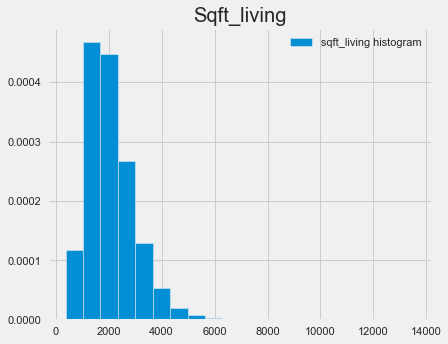

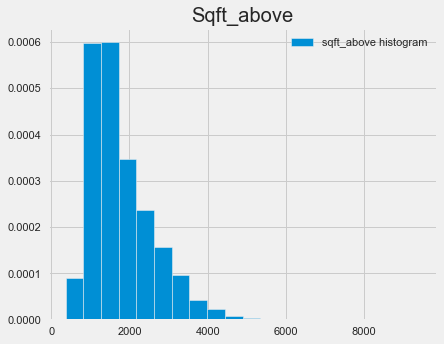

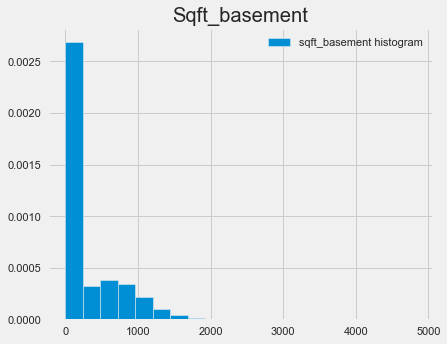

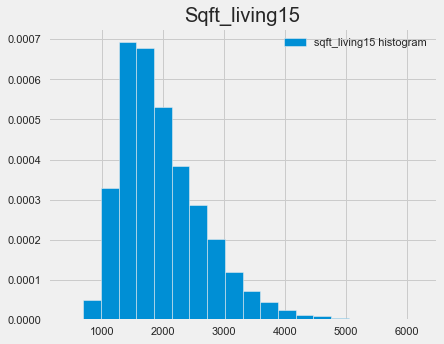

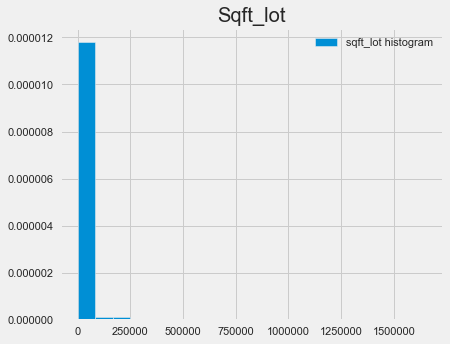

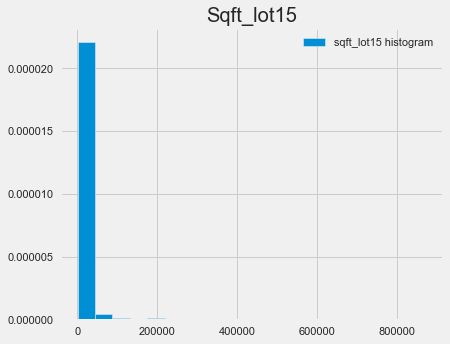

In [285]:
# get rid of price to look at the distributions of just the numeric features without the target
df_nums.drop('price', axis=1, inplace=True)
# hist plot
sub_hists(df_nums)

    Although sqft_living15 didn't have as much linearity with price as other candidates, it appears
    to have the most normal distribution out of all of them.

### KDEs

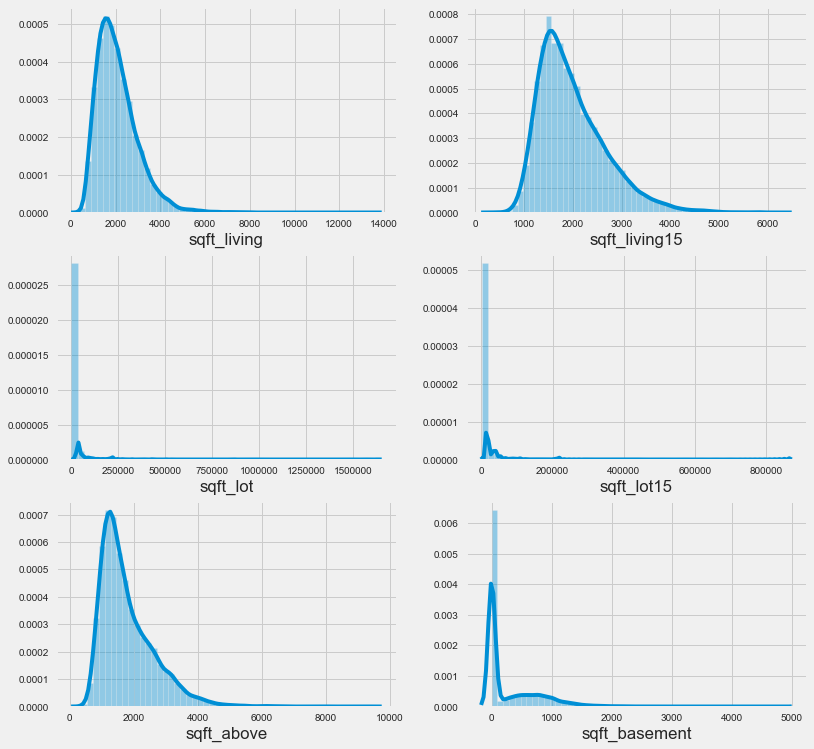

In [360]:
# Kernel Density Estimates (distplots) for square-footage variables
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,12))
sns.distplot(df['sqft_living'], ax=ax[0][0])
sns.distplot(df['sqft_living15'], ax=ax[0][1])
sns.distplot(df['sqft_lot'], ax=ax[1][0])
sns.distplot(df['sqft_lot15'], ax=ax[1][1])
sns.distplot(df['sqft_above'], ax=ax[2][0])
sns.distplot(df['sqft_basement'], ax=ax[2][1])

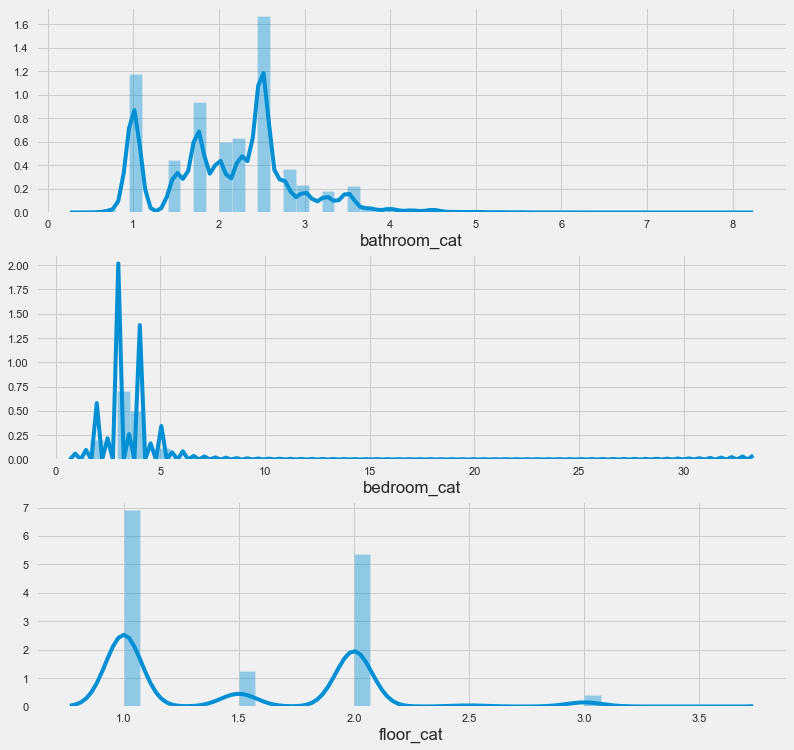

In [320]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12,12))
sns.distplot(df['bathroom_cat'], ax=ax[0])
sns.distplot(df['bedroom_cat'], ax=ax[1])
sns.distplot(df['floor_cat'], ax=ax[2])

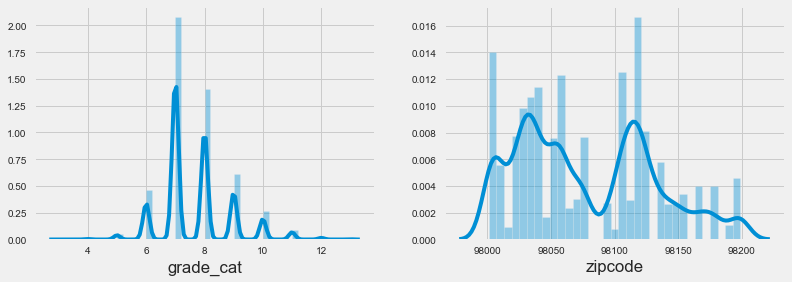

In [363]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.distplot(df['grade_cat'], ax=ax[0])
sns.distplot(df_drops['zipcode'], ax=ax[1]) # look at actual zipcode value dist instead of category

### Geographic

**QUESTION: Does geography (location) have any relationship with the values of each categorical variable?**

In [323]:
# bring lat / long columns back in for plotting geographic distribution of ordinal categories

latlong = ['lat', 'long']
latlong_df = df_drops[latlong]
geo_cats_df = pd.concat([df_cats, latlong_df], axis=1)

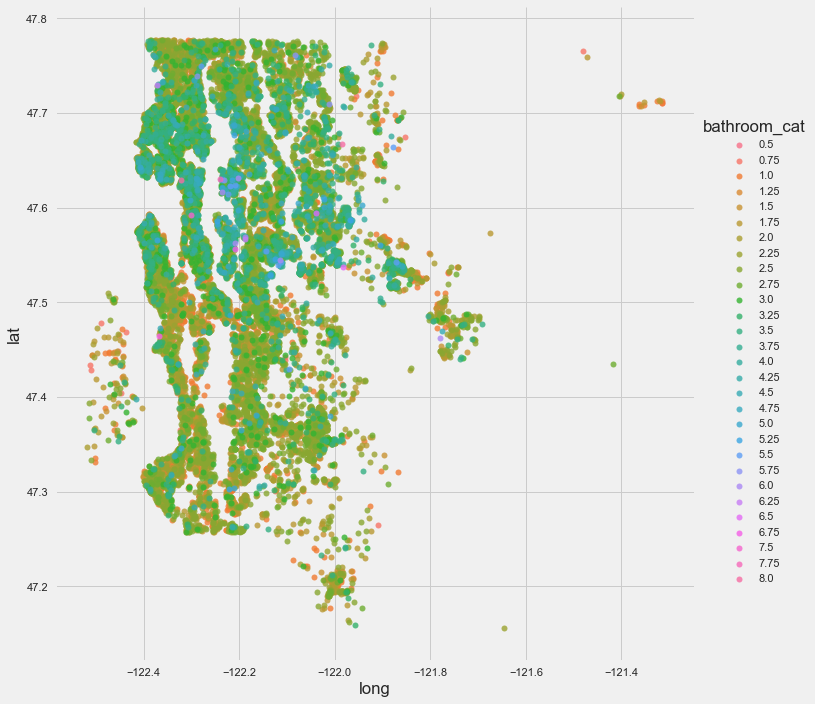

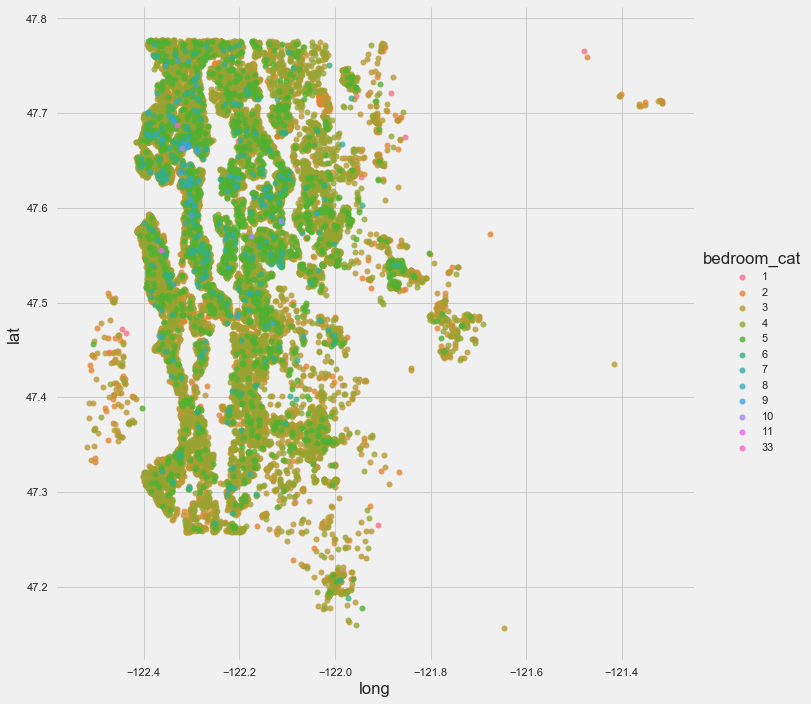

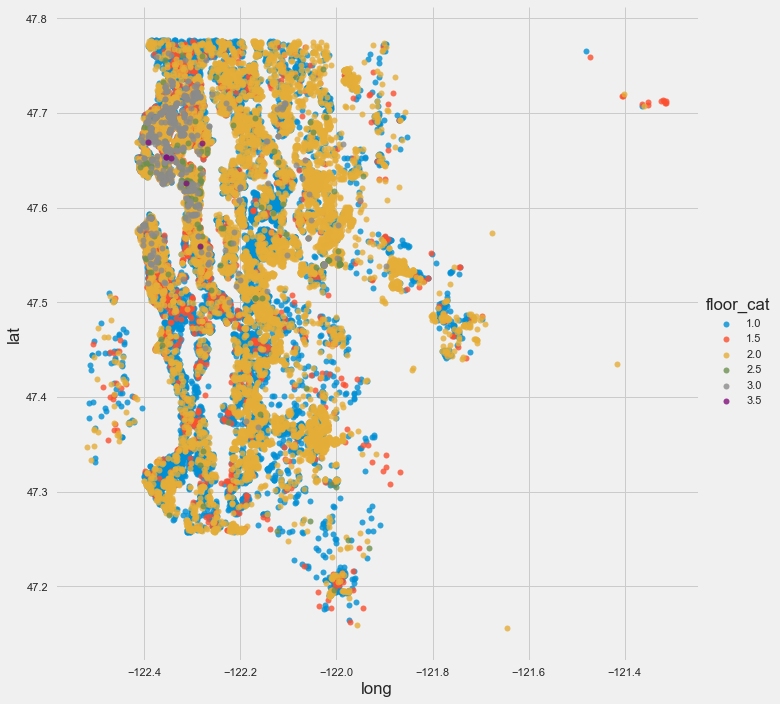

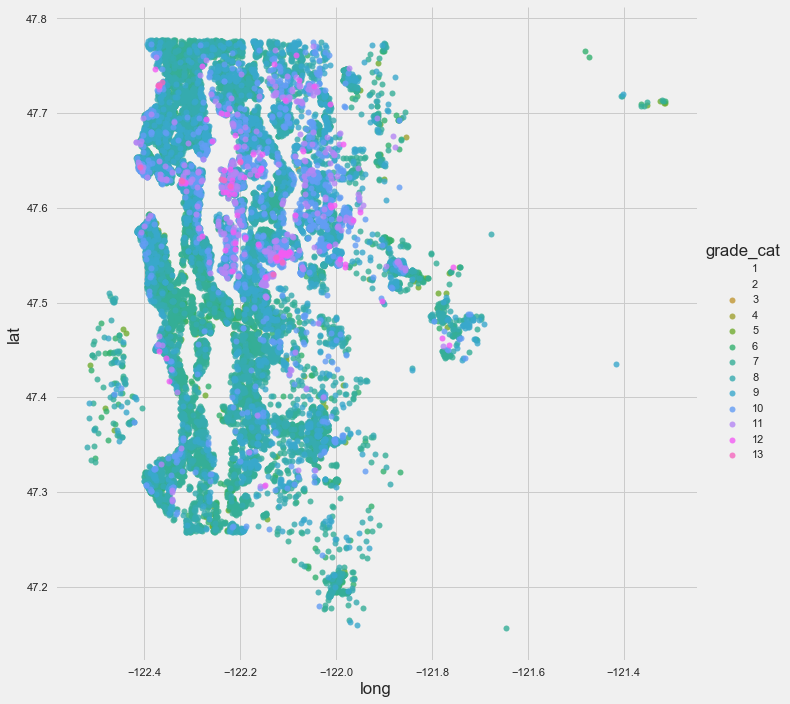

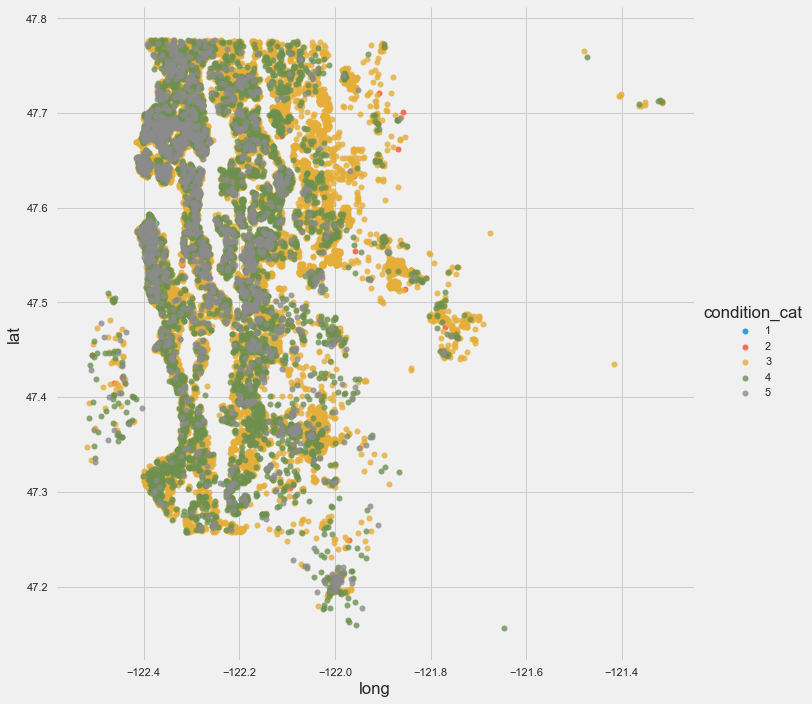

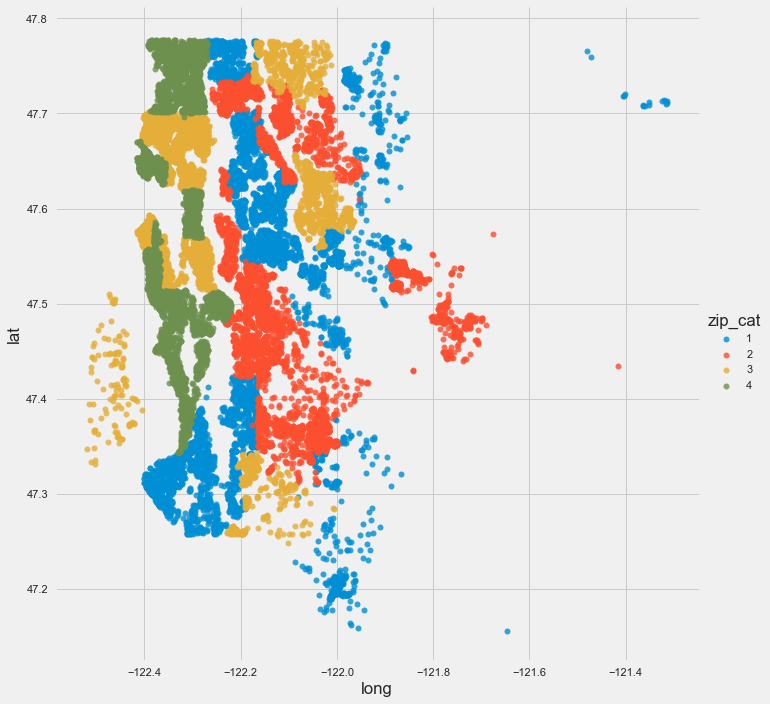

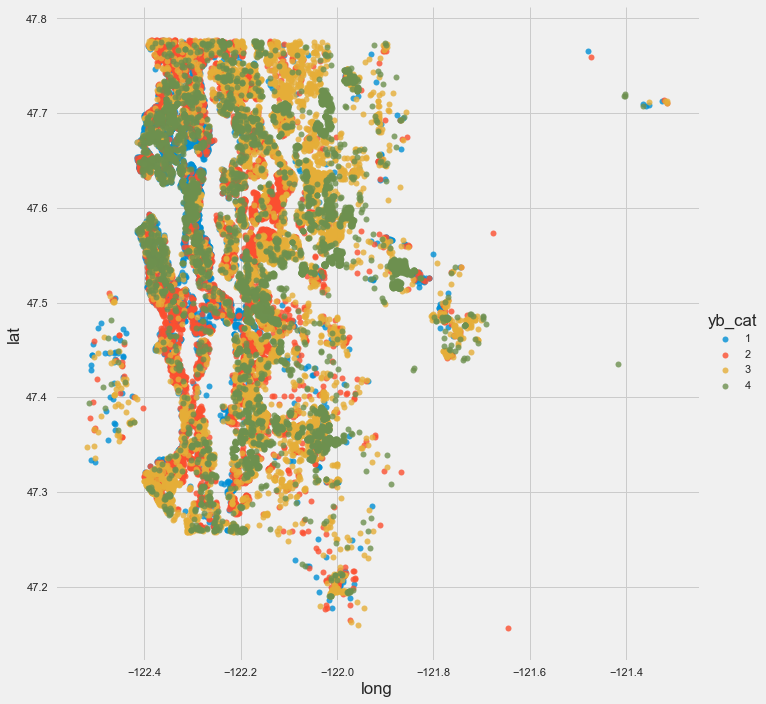

In [324]:
# run (ordinal) categorical features through lmplot as a forloop to plot geographic distribution visual

for x in cats:
    sns.lmplot(data=geo_cats_df, x="long", y="lat", fit_reg=False, hue=x, height=10)
plt.show()

    The highest grade properties appear to be most dense in the upper left quadrant. 
    Since we already know that grade has a strong correlation with price, we can 
    posit more confidently that grade, location, and price are all related.
    
    Note: if we were to look at an actual map, we'd see this is Seattle.

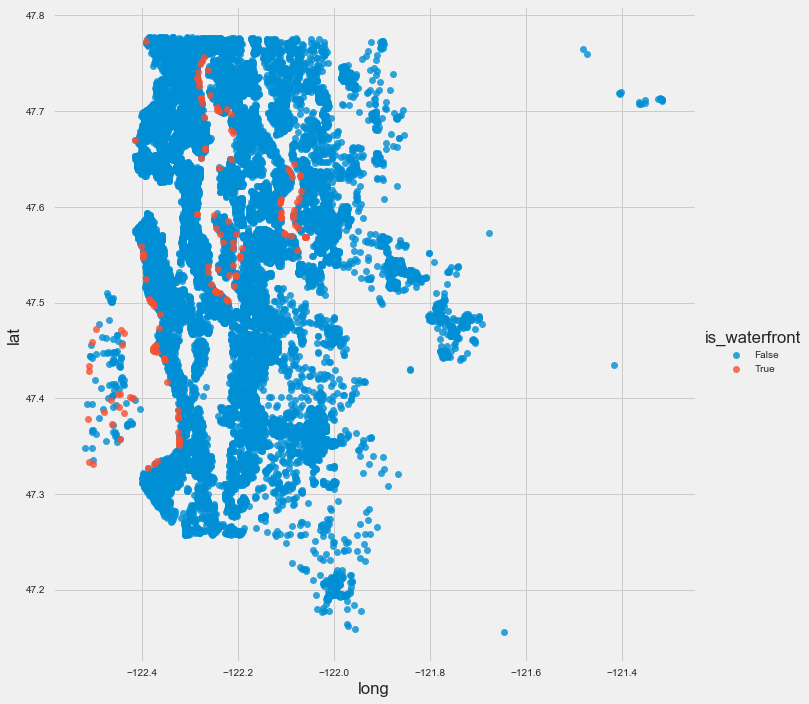

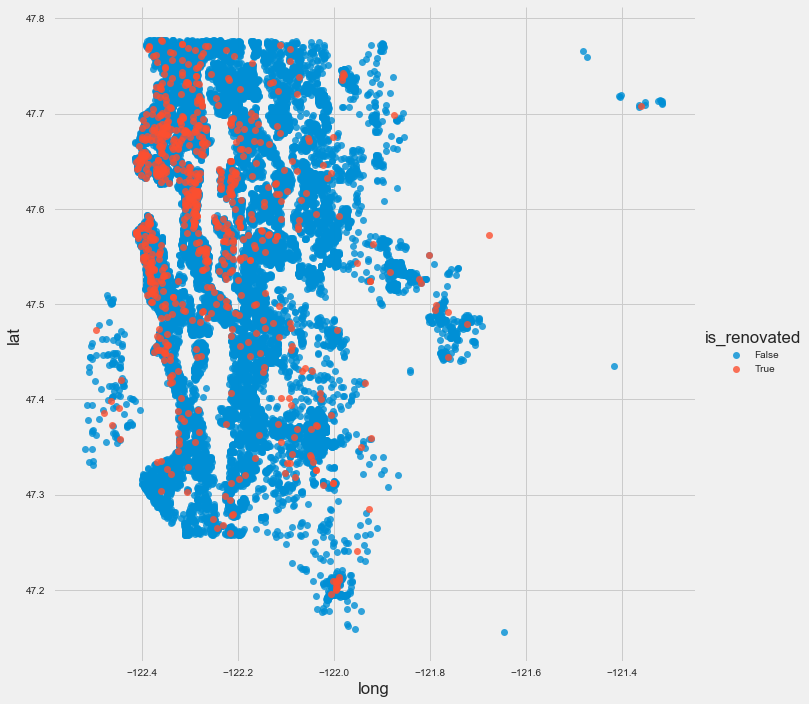

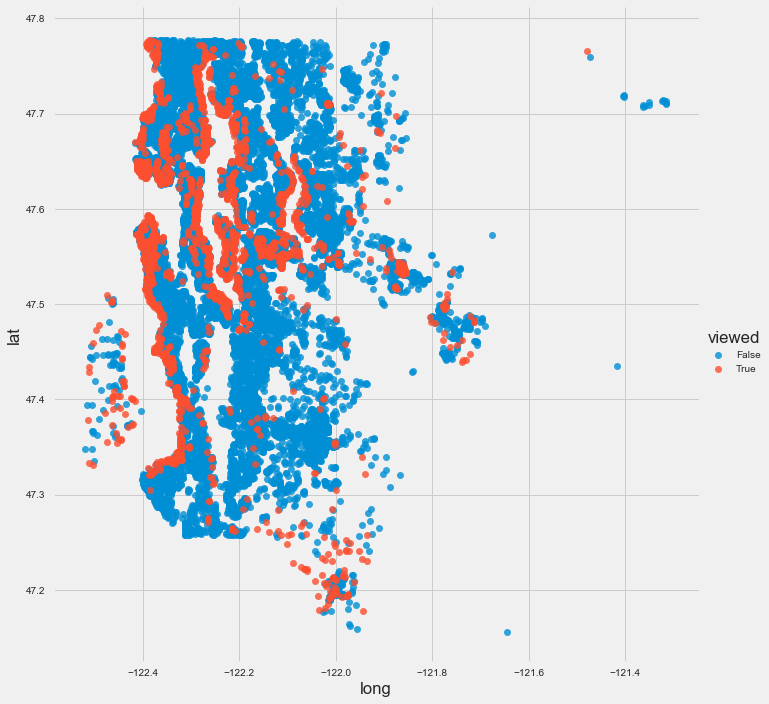

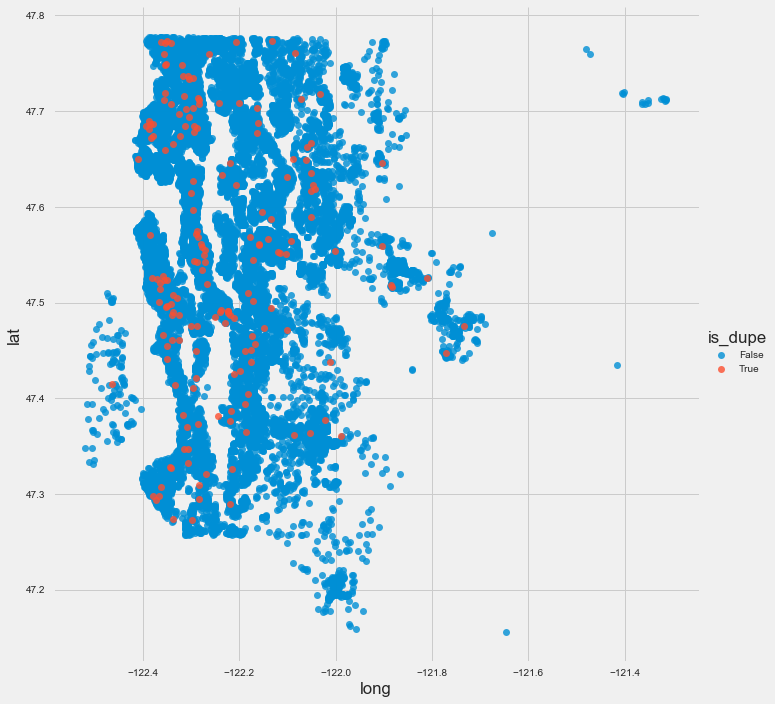

In [149]:
# binary/categorical:
binned = ['is_waterfront', 'is_renovated', 'viewed', 'is_dupe']

# bring lat / long columns back in for plotting geographic distribution of ordinal categories

geo_bins = pd.concat([df_binned, latlong_df], axis=1)
geo_bins

# run binned features through lmplot as a forloop to plot geographic distribution visual
for x in binned:
    sns.lmplot(data=geo_bins, x="long", y="lat", fit_reg=False, hue=x, height=10)
plt.show()

    Some obvious but also some interesting things to observe in the above lmplots:
    
    The good news is that waterfront properties do indeed show up as being on the water, 
    so we can rest assured that data is valid. Unfortunately as we saw earlier, this doesn't 
    seem to correlate much with price. 
    
    'is_dupe' (which represents properties that sold twice in the 2 year period of this dataset)
    tells us pretty much nothing about anything. At least not on its own here.
    
    Probably the most surprising observation is 'viewed'. They almost all line up with the 
    coastline, or very close to the water. This may not mean anything but it is worth noting.
    
    Lastly, is_renovated is pretty densely clumped up in the northwest quadrant (again, Seattle).
    We can assume therefore that a lot of renovations are taking place in the city. Not entirely
    useful but worth mentioning neverthless.

### Box Plots

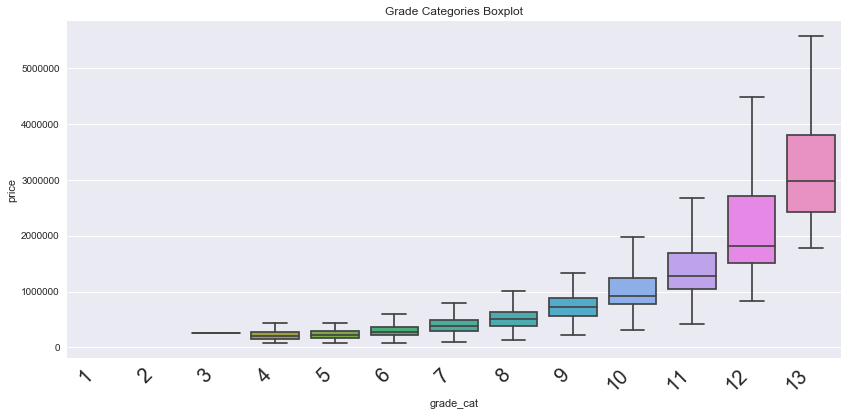

In [325]:
x = df['grade_cat']
y = df['price']

plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Grade Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('grade_cat')
ax.set_ylabel('price')
fig.tight_layout()

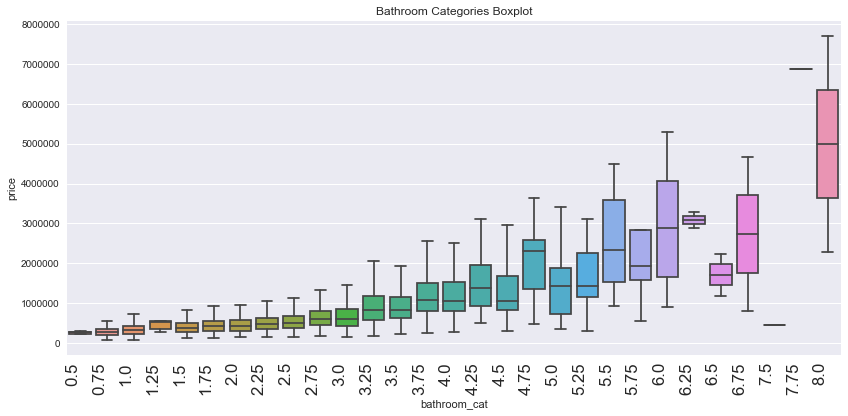

In [326]:
x = df['bathroom_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Bathroom Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('bathroom_cat')
ax.set_ylabel('price')
fig.tight_layout()

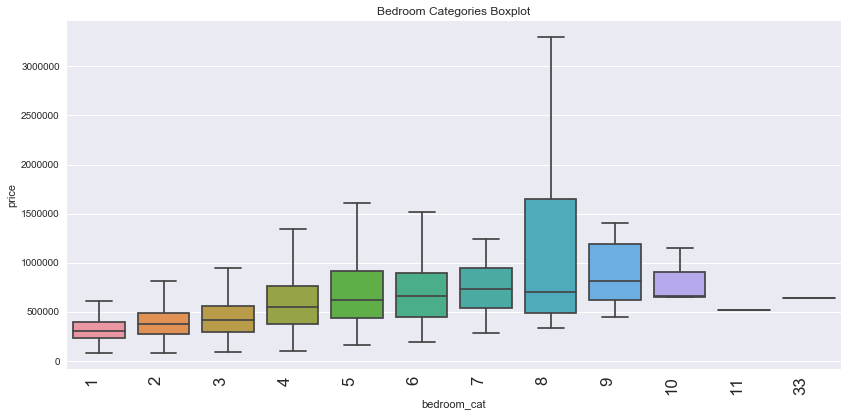

In [327]:
x = df['bedroom_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Bedroom Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('bedroom_cat')
ax.set_ylabel('price')
fig.tight_layout()

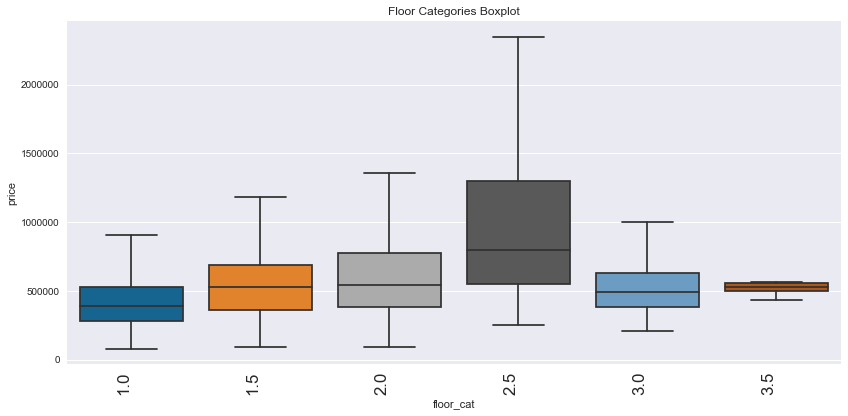

In [331]:
x = df['floor_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Floor Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('floor_cat')
ax.set_ylabel('price')
fig.tight_layout()

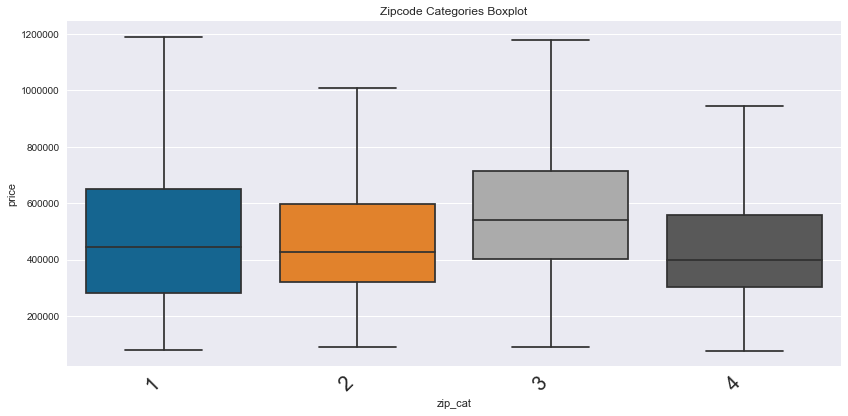

In [329]:
x = df['zip_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)

# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='zipcode categories boxplot'
ax.set_title(title.title())
ax.set_xlabel('zip_cat')
ax.set_ylabel('price')
fig.tight_layout()

    Category 3 for zipcode seems to be a good candidate for higher priced homes.

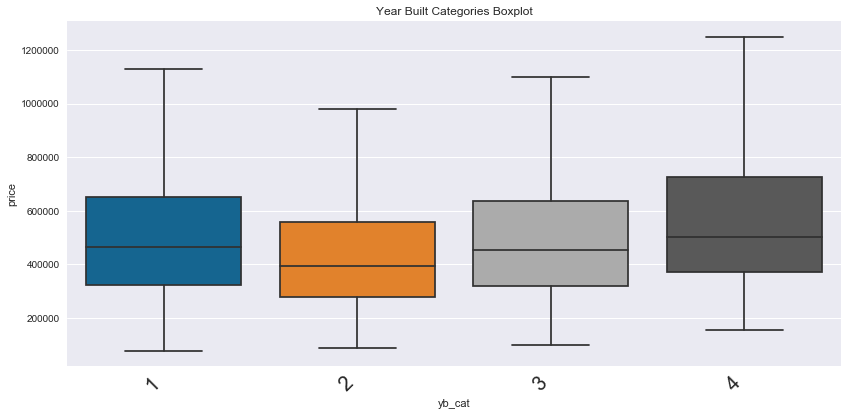

In [330]:
x = df['yb_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Year Built Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('yb_cat')
ax.set_ylabel('price')
fig.tight_layout()

    This tells us pretty much nothing other than newer homes sell at a higher price point. As far as making a and 
    prediction goes, we can only really use this to suggest building a new property rather than renovating.

## Regression Plots

In [364]:
def plot_reg(data, feature, target):
    sns.regplot(x=feature, y=target, data=data)
    plt.show()

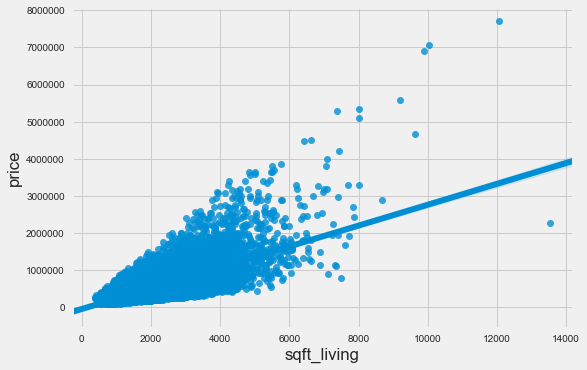

In [365]:
plot_reg(df, 'sqft_living', 'price')

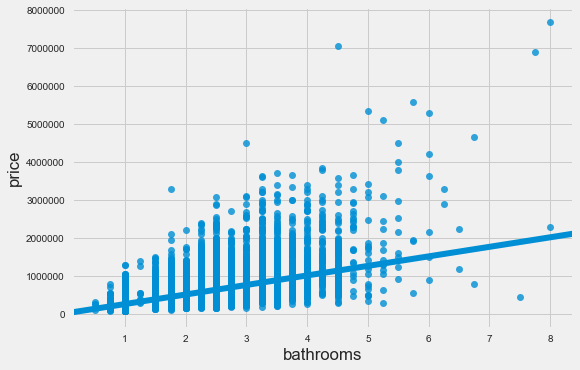

In [372]:
plot_reg(df_drops, 'bathrooms', df.price)

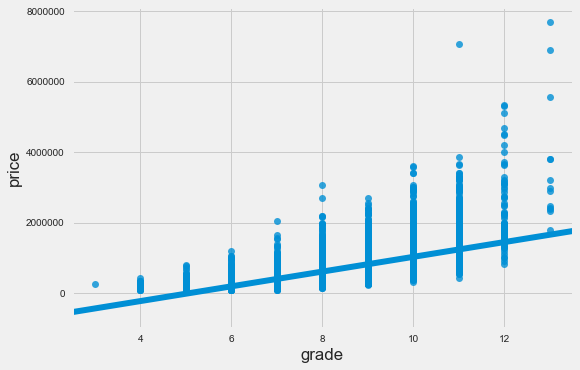

In [373]:
plot_reg(df_drops, 'grade', df.price)

# FIT AN INITIAL MODEL:
Various forms, detail later...
Assessing the model:
Assess parameters (slope,intercept)
Check if the model explains the variation in the data (RMSE, F, R_square)
Are the coeffs, slopes, intercepts in appropriate units?
Whats the impact of collinearity? Can we ignore?
Revise the fitted model
Multicollinearity is big issue for lin regression and cannot fully remove it
Use the predictive ability of model to test it (like R2 and RMSE)
Check for missed non-linearity
Holdout validation / Train/test split
use sklearn train_test_split

In [ ]:
#import df (pre-drops) with pickle
#with open('data.pickle', 'rb') as f:
#    df_pred = pickle.load(f)
    

In [434]:
# cols to drop as candidates for model
hot_drop = ['is_waterfront', 'is_renovated', 'viewed', 'yb_2', 'yb_3', 'yb_4', 'floors', 'bedrooms', 'sqft_living15']

# drop >> df.drop(hot_drop, axis=1, inplace=True)
df_pred.drop(hot_drop, axis=1, inplace=True)

In [449]:
# verify dropped columns
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 7 columns):
price          21420 non-null float64
bathrooms      21420 non-null float64
sqft_living    21420 non-null int64
zip_2          21420 non-null uint8
zip_3          21420 non-null uint8
zip_4          21420 non-null uint8
grade          21420 non-null float64
dtypes: float64(3), int64(1), uint8(3)
memory usage: 899.5 KB


In [450]:
abs(df_pred.corr()) > .7

price  bathrooms  sqft_living  zip_2  zip_3  zip_4  grade
price         True      False         True  False  False  False  False
bathrooms    False       True         True  False  False  False  False
sqft_living   True       True         True  False  False  False   True
zip_2        False      False        False   True  False  False  False
zip_3        False      False        False  False   True  False  False
zip_4        False      False        False  False  False   True  False
grade        False      False         True  False  False  False   True

In [451]:
# Raw data check

from statsmodels.formula.api import ols
outcome = 'price'
x_cols = df_pred.drop('price', axis=1).columns
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_pred).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4475.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        03:33:08   Log-Likelihood:            -2.9618e+05
No. Observations:               21420   AIC:                         5.924e+05
Df Residuals:                   21413   BIC:                         5.924e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.521e+05   7898.683    -44.581      0.000   -3.68e+05   -3.37e+05
bathrooms    -2.34e+05   2.56e+04     -9.141      0.000   -2.84e+05   -1.84e+05
sqft_living   211.0925      3.290     64.164      0.000     204.644     217.541
zip_2       -2.541e+04   4723.220     -5.380      0.000   -3.47e+04   -1.62e+04
zip_3        1.069e+05   4588.831     23.302      0.000    9.79e+04    1.16e+05
zip_4         6.67e+04   4861.991     13.719      0.000    5.72e+04    7.62e+04
grade        1.001e+06   2.27e+04     44.151      0.000    9.57e+05    1.05e+06
==============================================================================
Omnibus:                    17273.623   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1119778.223
Skew:                           3.417   Prob(JB):                         0.00
Kurtosis:                      37.756   Cond. No.                     3.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scaling / Normalization

The dataset's remaining features vary significantly in magnitude which will throw off the R2 coefficient (essentially giving the false impression that some variables are less important).

### Log Transformation

Reduces skewness and variability of data to improve regression algorithm.

In [478]:
# Log Transform

#x = np.linspace(start=-100, stop=100, num=10**3)
#y = np.log(x)
#plt.plot(x,y)

# Make data more normal (improve skewness)

#data_log = pd.DataFrame([])
#data_log['log_sqftliv'] = np.log(df_pred['sqft_living'])
#data_log['log_bathrooms'] = np.log(df_pred['bathrooms'])
#data_log['log_grade'] = np.log(df_pred['grade'])

### MinMax Scaling

Reduces skewness and variability of data to improve regression algorithm.

In [500]:
# create empty dataframe for scaled features
data_cont_scaled = pd.DataFrame([])

# minmax scaling on sqft_living:
sqftliv = df_pred['sqft_living']
scaled_sqftliv = (sqftliv - min(sqftliv)) / (max(sqftliv) - min(sqftliv))
data_cont_scaled['sqftliv'] = scaled_sqftliv

In [501]:
# This did nothing...let's try standardization
#minmax scaling on grade

#grade = df_pred['grade']
#scaled_grade = (grade - min(grade)) / (max(grade) - min(grade))
#data_cont_scaled['grade'] = scaled_grade

# minmax scaling on bathrooms
#bathrooms = df_pred['bathrooms']
#scaled_bathrooms = (bathrooms - min(bathrooms)) / (max(bathrooms) - min(bathrooms))
#data_cont_scaled['bathrooms'] = scaled_bathrooms

# This did nothing... let's try mean normalization

#log_grade = data_log['log_grade']
#scaled_grade = (log_grade - np.mean(log_grade)) / np.sqrt(np.var(log_grade))
#data_cont_scaled['grade'] = scaled_grade


#log_bathrooms = data_log['log_bathrooms']
#scaled_bathrooms = (log_bathrooms - np.mean(log_bathrooms)) / np.sqrt(np.var(log_bathrooms))
#data_cont_scaled['bathrooms'] = scaled_bathrooms


# This did nothing...probably because they're categorical?
# mean normalization
#log_grade = data_log['log_grade']
#scaled_grade = (log_grade - np.mean(log_grade)) / (max(log_grade) - min(log_grade))
#data_cont_scaled['grade'] = scaled_grade

#log_bathrooms = data_log['log_bathrooms']
#scaled_bathrooms = (log_bathrooms - np.mean(log_bathrooms)) / (max(log_bathrooms) - min(log_bathrooms))
#data_cont_scaled['bathrooms'] = scaled_bathrooms


In [502]:
df_pred['zip'] = df_drops['zipcode']
df_pred['bath'] = df_drops['bathrooms']
df_pred['grade'] = df_drops['grade']
df_pred['zip'] = df_pred['zip'].astype('category')
df_pred['bath'] = df_pred['bath'].astype('category')
df_pred['grade'] = df_pred['grade'].astype('category')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2b35c978>]],
      dtype=object)

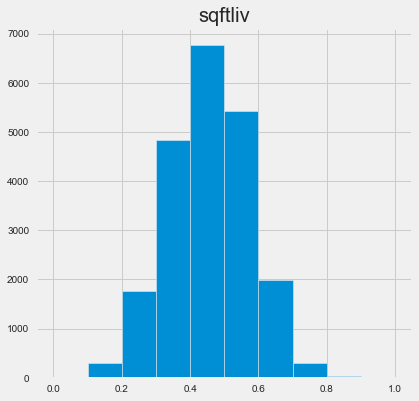

In [503]:
data_cont_scaled.hist(figsize=(6,6))

In [495]:
# NOPE this just created a bunch of NaNs for grade and bathroom

# create a new dataframe and add dummy_vars
data_fin = pd.DataFrame([])
data_fin['sqftliv'] = scaled_sqftliv
#grade_dummies = pd.get_dummies(df_pred['grade'], prefix='grade')
#bathroom_dummies = pd.get_dummies(df_pred['bathrooms'], prefix='bath')
#zip_dummies = pd.get_dummies(df_pred['zip'], prefix='zip')
data_fin['grade'] = scaled_grade
data_fin['bath'] = scaled_bathrooms
price = df_pred['price']
data_fin = pd.concat([price, data_fin], axis=1)
data_fin


In [ ]:
# Run OLS on data using formula y~X where w n predictors X is x, + x1 + ... xn
import statsmodels.api as sm
from statsmodels.formula.api import ols
outcome = 'price'
predictors = data_fin.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=data_fin).fit()
model.summary()

## Stepwise Selection
Start with empty model, find lowest p-value and perform a forward-backward feature selection based on pvalue

## Forward Selection

In [376]:
# Choose a linear model by forward selection
# The function below optimizes adjusted R-squared by adding features that help the most one at a time
# until the score goes down or you run out of features.

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [436]:
model = forward_selected(df_pred, 'price')
print(model.model.formula)
print(model.rsquared_adj)

price ~ sqft_living + grade + zip_3 + zip_4 + bedrooms + sqft_living15 + zip_2 + bathrooms + 1
0.5629928750344877


In [439]:
model = forward_selected(df_pred, 'price')
print(model.model.formula)
print(model.rsquared_adj)

price ~ sqft_living + grade + zip_3 + zip_4 + bedrooms + sqft_living15 + zip_2 + bathrooms + 1
0.5629928750344877


Explaining/Phrasing R-Squared values
An obtained R-squared value of say 0.85 can be put into a statement as

85% of the variations in dependent variable  𝑦  are explained by the independent variable in our model.

In [ ]:
# Alternative method

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics



# Define selector function combining RFE and linear regression
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=1)

# Drop already scaled variables for this feature testing
X = df_run.loc[:,~(df_run.columns.str.startswith(('bins','zip')))]
X = X.drop('price',axis=1)

# RUNNING RFE ON THE UNSCALED DATA(DEMONSTRATION)
Y = df_run['price']
# Y = df_run['logz_price']
# X = df_run.drop(['price'],axis=1)


# Run regressions on X,Y 
selector = selector.fit(X,Y)

# Saving unscaled rankings for demo purposes
no_scale = selector.ranking_




# Scale all variables to value between 0-1 to use RFE to determine which features are the most important for determining price?
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale the data before running RFE
print('Consider revisiting this step and dummy-coding zipcode.')

# ONLY SCALE NON-CATEGORICAL, ONE-HOT CATEGORICAL
scaler.fit(X,Y)
scaled_data = scaler.transform(X)
scaled_data.shape

In [ ]:
# Running RFE with scaled data
selector = selector.fit(scaled_data, Y) 
scaled = selector.ranking_
type(scaled)


# Create a dataframe with the ranked values of each feature for both scaled and unscaled data
best_features = pd.DataFrame({'columns':X.columns, 'scaled_rank' : scaled,'unscaled_rank':no_scale})
best_features.set_index('columns',inplace=True)


# Display dataframe (sorted based on unscaled rank)
best_features.sort_values('unscaled_rank')

In [ ]:
# Concatenate X,Y for OLS
df_run_ols = pd.concat([Y,X],axis=1)

# Import packages
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats

# Enter equation for selected predictors: (use C to run as categorical) 
# f1 = 'price~C(codezipcode)+C(grade)+sca_sqft_living+sca_sqft_living15' # 0.8 r1 Adjusted
f1 = 'price~C(codezipcode)+grade+sca_sqft_living+sca_sqft_living15' 

# Run model and report sumamry
model = smf.ols(formula=f1, data=df_run_ols).fit()
model.summary()

## Outliers

In [ ]:
# Tukey's method using IQR to eliminate 
def detect_outliers(df, n, features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)        
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        return multiple_outliers 
# Outliers_to_drop = detect_outliers(data,2,["col1","col2"])
# df.loc[Outliers_to_drop] # Show the outliers rows
# Drop outliers
# data= data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)



# GET OUTLIER INDICES AND REPORT 

outliers_to_drop = {}

for col in vars_to_clean:
    outliers_to_drop[col] = detect_outliers(df,0,[col])
# outliers_to_drop.keys()
# outliers_to_drop.values()

# Print out # of outliers
for k, v in outliers_to_drop.items():
    print(f'col: {k} has {len(v)} outliers. ({round(len(v)/len(df),2)*100}%)' )

col: price has 1131 outliers. (5.0%)
col: bedrooms has 511 outliers. (2.0%)
col: sqft_living has 557 outliers. (3.0%)
col: bathrooms has 546 outliers. (3.0%)
col: sqft_living15 has 532 outliers. (3.0%)

# Intialize df_norm with df's values
df_norm=df.copy()

# Iterate throught outliers_to_drop dictionary to replace outliers with np.nan
for k, v in outliers_to_drop.items():
    df_norm.loc[v,k] = np.nan # axis=0,inplace=True)

# Display null values
df_norm.isna().sum()


# REMOVING OUTLIERS FROM PRICE

drop_col = 'sqft_living'

print(f'for {drop_col}:')
print(f'# of intial rows: {len(df_norm)}')
df_norm.dropna(subset=[drop_col],inplace=True)
print(f'# after dropping rows: {len(df_norm)}')
print(f'\nOutliers remaining: \n{df_norm.isna().sum()}')


# REMOVING OUTLIERS FROM BATHROOMS
drop_col = 'bathrooms'

print(f'for {drop_col}:')
print(f'# of intial rows: {len(df_norm)}')
df_norm.dropna(subset=[drop_col],inplace=True)
print(f'# after dropping rows: {len(df_norm)}')
print(f'\nOutliers remaining: \n{df_norm.isna().sum()}')


# REMOVING OUTLIERS FROM SQFT_LIVING
drop_col = 'sqft_living15'

print(f'for {drop_col}:')
print(f'# of intial rows: {len(df_norm)}')
df_norm.dropna(subset=[drop_col],inplace=True)
print(f'# after dropping rows: {len(df_norm)}')
print(f'\nOutliers remaining: \n{df_norm.isna().sum()}')


features = df.columns
#['condition', 'grade','zipcode','sqft_living', 'bathrooms']
outliers_to_drop = detect_outliers(df, 2, features)
df.loc[outliers_to_drop]




outliers_to_drop

# Visualizations

In [ ]:
colormap = ('skyblue', 'salmon', 'lightgreen')
plt.figure()
pd.plotting.parallel_coordinates(df, 'price', cols=['sqft_living', 'grade_cat', 'zip_cat', 'bathroom_cat'], color=colormap);
pd.plotting.parallel_coordinates
#pd.plotting.scatter_matrix(df);

In [ ]:
import plotly.graph_objects as go

import pandas as pd

#df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['colorVal'],
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(range = [32000,227900],
                 constraintrange = [100000,150000],
                 label = "Block Height", values = df['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = df['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = df['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = df['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = df['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = df['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = df['HstW'])])
    )
)
fig.show()

##### TABLEAU HOW TO (temp)
Short how-to plot geo data in Tableau:
Load in your .csv dataset from your project.
Let it use data interpreter. It should identify zipcode as a location.
On your worksheet page:
For plotting each price for each house:
Drag the Measures Lat and Long onto the rows and columns boxes (top of sheet)
Drag the Measure price onto the Color Button under Marks.
It should now be listed at the bottom of the Marks panel.
Right-click and select "Dimension"
For plotting median income by zipcode:
Drag zipcode form the Dimensions panel onto the main graph window.
It will automatically load in map of location.
Drag price onto the color button (it will now appear in the Marks window)
Rich click on Price. Select "Measure" > Median
Customize map features by selecting "Map" > Map Layers on the Menu Bar.


In [ ]:
# https://www.youtube.com/watch?v=upBvuTqOy9k&feature=youtu.be

import plotly
plotly.offline.init_notebook_mode(connected=True)

import pandas as pd
import numpy as np

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [ ]:
data = go.Scatter(x=[1,2,3,4], y=[3,6,8,9], name='Blue')
layout = go.Layout(title='Random Scatter')

fig = go.Figure(data=data, layout=layout)

* "how did you pick the question(s) that you did?"
* "why are these questions important from a business perspective?"
* "how did you decide on the data cleaning options you performed?"
* "why did you choose a given method or library?"
* "why did you select those visualizations and what did you learn from each of them?"
* "why did you pick those features as predictors?"
* "how would you interpret the results?"
* "how confident are you in the predictive quality of the results?"
* "what are some of the things that could cause the results to be wrong?"

## DATE

In [ ]:
# group data by dates/months/years to explore comparison in market fluctuations

print(df.date.min())
print(df.date.max())

# Our dataset contains values spanning two years: beginning May 2014 to end of May 2015

In [ ]:
df.date.dt.year.value_counts(normalize=True)
# 2014    14622
# 2015     6975
# The majority of our data (67%) is from 2014

In [ ]:
df.date.dt.month.value_counts()

### Impact of date (month or year) on price
Question: are housing prices lower or higher in certain months (better to buy)?

In [ ]:
# create new columns for year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
# There does not appear to be any correlation whatsoever with 
weights = np.linspace(0,1)
np.corrcoef(df['month'], df['price'])
np.corrcoef(df['year'], df['price'])

In [ ]:
df.month.value_counts(normalize=True)

In [ ]:
# create variables for each series you want to pass into the xcols list and compare them against one
y_sub = 'price'
date_sub = ['year','month']

sub_scatter(date_sub, y_sub)

In [44]:
# check data discrepancies between duplicates (if any):

# 1 - compare price (house value) and date of sale:

# dupes         date        price
# 6021501535   12/23/2014   700,000
#               7/25/2014   430,000
    
# 4139480200   12/9/2014
# 7520000520   3/11/2015
# 3969300030   12/29/2014
# 2231500030   3/24/2015



#for df['id'] in df:
#    if df['id'] == 
#        print(f"{df.id} : {date} : {price}\n")
     #  4139480200
#dupes_id = dupes['id']
#dupes_price = dupes['price']

# 2 - compare other discrepancies and/or missing values 